# Práctica 1C - Inteligencia Artificial
**Grupo 16**
- Erik Karlgren Domercq
- David Bugoi
- Daniela Alejandra Córdova Porta

## Belén Díaz Agudo -  Facultad de Informática UCM
## Búsqueda local
En esta primera parte usaremos ejercicios paso a paso para familiarizarnos con la resolución de problemas sencillos de optimización, como la maximización o minimización de una función, o el problema de la mochila o del viajante, problemas conocidos cuya resolución se ha abordado con técnicas algorítmicas y que vamos a resolver utilizando algoritmos de búsqueda local. En la segunda parte de la práctica se pide resolver el problema de la organización de jornadas informáticas dado en el enunciado.

In [1]:
cd aima-python

/home/erik/Documents/University/2020-2021/1st semester/IA1/practicas-github/aima-python


## Parte 1. Algoritmo de escalada
Hill Climbing es un algoritmo de búsqueda local heurística utilizada para problemas de optimización.
Esta solución puede o no ser el óptimo global. El algoritmo es una variante del algoritmo de generación y prueba.


En general, el algoritmo funciona de la siguiente manera:
- Evaluar el estado inicial.
- Si es igual al estado del objetivo, terminamos.
- Encuentra un estado vecino al estado actual
- Evaluar este estado. Si está más cerca del estado objetivo que antes, reemplace el estado inicial con este estado y repita estos pasos.


Usaremos la implementación de AIMA que está en el módulo search.py

```python
def hill_climbing(problem):
    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. [Figure 4.2]"""
    current = Node(problem.initial)
    while True:
        neighbors = current.expand(problem)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors,
                                 key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
            break
        current = neighbor
    return current.state
 ```


### TSP (<i>Travelling Salesman Problem</i>): el problema del viajante
Dado un conjunto de ciudades y la distancia entre cada par de ciudades, el problema es encontrar la ruta más corta posible que visite cada ciudad exactamente una vez y regrese al punto de partida. Es un problema NP hard. No existen una solución de coste polinomial. 

In [2]:
## Resolveremos el problema del viajante TSP para encontrar una solución aproximada.
from search import *

class TSP_problem(Problem):

    def two_opt(self, state):
        """ Neighbour generating function for Traveling Salesman Problem """
        neighbour_state = state[:]
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
        neighbour_state[left: right + 1] = reversed(neighbour_state[left: right + 1])
        return neighbour_state

    def actions(self, state):
        """ action that can be excuted in given state """
        return [self.two_opt]

    def result(self, state, action):
        """  result after applying the given action on the given state """
        return action(state)

    def path_cost(self, c, state1, action, state2):
        """ total distance for the Traveling Salesman to be covered if in state2  """
        cost = 0
        for i in range(len(state2) - 1):
            cost += distances[state2[i]][state2[i + 1]]
        cost += distances[state2[0]][state2[-1]]
        return cost

    def value(self, state):
        """ value of path cost given negative for the given state """
        return self.path_cost(None, None, None, state)

Resolveremos el TSP para las ciudades de la lista de ciudades de Rumanía.

```python
['Arad', 'Bucharest', 'Craiova', 'Drobeta', 'Eforie', 'Fagaras', 'Giurgiu', 'Hirsova', 'Iasi', 'Lugoj', 'Mehadia', 'Neamt', 'Oradea', 'Pitesti', 'Rimnicu', 'Sibiu', 'Timisoara', 'Urziceni', 'Vaslui', 'Zerind']
```

In [3]:
# Usaremos la siguiente representacion del libro AIMA para el mapa de Rumanía.

# Distancias entre las ciudades del mapa
romania_map = UndirectedGraph(dict(
    Arad      = dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest = dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova   = dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta   = dict(Mehadia=75),
    Eforie    = dict(Hirsova=86),
    Fagaras   = dict(Sibiu=99),
    Hirsova   = dict(Urziceni=98),
    Iasi      = dict(Vaslui=92, Neamt=87),
    Lugoj     = dict(Timisoara=111, Mehadia=70),
    Oradea    = dict(Zerind=71, Sibiu=151),
    Pitesti   = dict(Rimnicu=97),
    Rimnicu   = dict(Sibiu=80),
    Urziceni  = dict(Vaslui=142)))

# Coordenadas. Son para renderizar el grafo.
romania_map.locations = dict(
    Arad    =  (91, 492), Bucharest = (400, 327), Craiova  = (253, 288),
    Drobeta = (165, 299), Eforie    = (562, 293), Fagaras  = (305, 449),
    Giurgiu = (375, 270), Hirsova   = (534, 350), Iasi     = (473, 506),
    Lugoj   = (165, 379), Mehadia   = (168, 339), Neamt    = (406, 537),
    Oradea  = (131, 571), Pitesti   = (320, 368), Rimnicu  = (233, 410),
    Sibiu   = (207, 457), Timisoara =  (94, 410), Urziceni = (456, 350),
    Vaslui  = (509, 444), Zerind    = (108, 531))

Es bastante sencillo entender este `romania_map`. El primer nodo **Arad** tiene tres vecinos llamados **Zerind**, **Sibiu**, **Timisoara**. Cada uno de estos nodos son 75, 140, 118 unidades aparte de **Arad** respectivamente. Y lo mismo ocurre con otros nodos.

Y `romania_map.locations` contiene las posiciones de cada uno de los nodos. 
Como heurística se puede usar la distancia en línea recta o la distancia manhattan (que es diferente de la proporcionada en `romania_map`) entre dos ciudades.

In [4]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


In [5]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

In [6]:
# Descomentar para mostrar el mapa
# from notebook import show_map, final_path_colors, display_visual
# import matplotlib

# show_map(romania_graph_data)

In [7]:
## el siguiente código crea un diccionario y calcula y añade al diccionario la distancia manhattan entre las ciudades. 
import numpy as np

distances = {}
all_cities = []

for city in romania_map.locations.keys():
    distances[city] = {}
    all_cities.append(city)
    
all_cities.sort()
print(all_cities)

for name_1, coordinates_1 in romania_map.locations.items():
        for name_2, coordinates_2 in romania_map.locations.items():
            distances[name_1][name_2] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])
            distances[name_2][name_1] = np.linalg.norm(
                [coordinates_1[0] - coordinates_2[0], coordinates_1[1] - coordinates_2[1]])

['Arad', 'Bucharest', 'Craiova', 'Drobeta', 'Eforie', 'Fagaras', 'Giurgiu', 'Hirsova', 'Iasi', 'Lugoj', 'Mehadia', 'Neamt', 'Oradea', 'Pitesti', 'Rimnicu', 'Sibiu', 'Timisoara', 'Urziceni', 'Vaslui', 'Zerind']


In [8]:
# Creamos una instancia del problema TSP con la lista de ciudades anterior que se na extraido del mapa.
# En el mapa hay informacion de las distancias que se utilizan en la clase TSP_problem para calcular el coste y las heurísticas.
tsp = TSP_problem(all_cities)

In [9]:
## Redefinimos el hill climbing de AIMA para que el método de generacion de vecinos sea acceder al grafo que 
## hemos definido para el TSP

def hill_climbing(problem):
    
    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. [Figure 4.2]"""
    
    def find_neighbors(state, number_of_neighbors=100):
        """ finds neighbors using two_opt method """
        
        neighbors = []
        
        for i in range(number_of_neighbors):
            new_state = problem.two_opt(state)
            neighbors.append(Node(new_state))
            state = new_state
            
        return neighbors

    # as this is a stochastic algorithm, we will set a cap on the number of iterations
    iterations = 10000
    
    current = Node(problem.initial)
    while iterations:
        neighbors = find_neighbors(current.state)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors,
                                     key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
            current.state = neighbor.state
        iterations -= 1
        
    return current.state

In [10]:
# Y lo resolvemos con escalada. 
%time hill_climbing(tsp)

CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 11.2 s


['Arad',
 'Bucharest',
 'Craiova',
 'Drobeta',
 'Eforie',
 'Fagaras',
 'Giurgiu',
 'Hirsova',
 'Iasi',
 'Lugoj',
 'Mehadia',
 'Neamt',
 'Oradea',
 'Pitesti',
 'Rimnicu',
 'Sibiu',
 'Timisoara',
 'Urziceni',
 'Vaslui',
 'Zerind']

### Ejercicio 1. Resuelve el problema TSP con el algoritmo de escalada por máxima pendiente en el mapa de ciudades de Rumanía y explica el resultado obtenido. 

**Realiza un análisis razonado de las propiedades del algoritmo: eficiencia y optimalidad en base a la ejecución.**

Este algoritmo encuentra el óptimo local, que puede ser o no el óptimo global, porque solo considera los vecinos en cada estado y coge siempre el mejor. Sin embargo, gracias a ello llega rápidamente a dicho óptimo, que en general es el local, aunque depende del problema.

**¿Ha encontrado el algoritmo el óptimo global? ¿Ha encontrado la misma solución en distintas ejecuciones?
Sólo se pide hacer una comparativa teórica (breve) con cómo se comporta este algoritmo y relacionarlo con otros algoritmos vistos en clase. Opcionalmente se puede hacer la comparativa real con algún algoritmo de búsqueda exhaustiva.**

El algoritmo encuentra normalmente lo que parecen ser óptimos globales con valor 1589.8433308050924, aunque perfectamente podrían ser óptimos locales. Debido al comportamiento aleatorio de `two_opt` de vez en cuando encuentra peores resultados.

Hemos modificado `hill_climbing` para que minimice y `value()` de `TSP_problem` no multiplique por -1.

In [11]:
# hemos obtenido las siguientes soluciones en diferentes ejecuciones
sol1 = ['Arad','Timisoara','Lugoj', 'Mehadia', 'Drobeta', 'Craiova', 'Pitesti', 'Giurgiu', 'Bucharest',
        'Urziceni', 'Eforie', 'Hirsova', 'Vaslui', 'Iasi', 'Neamt', 'Fagaras', 'Rimnicu', 'Sibiu', 'Oradea',
         'Zerind']
sol2 = ['Mehadia', 'Drobeta', 'Craiova', 'Pitesti', 'Giurgiu', 'Bucharest', 'Urziceni', 'Eforie', 'Hirsova',
        'Vaslui', 'Iasi', 'Neamt', 'Fagaras', 'Rimnicu', 'Sibiu', 'Oradea', 'Zerind', 'Arad', 'Timisoara',
        'Lugoj']
sol3 = ['Hirsova', 'Eforie', 'Urziceni', 'Bucharest', 'Giurgiu', 'Craiova', 'Drobeta', 'Mehadia', 'Lugoj',
        'Timisoara', 'Arad', 'Zerind', 'Oradea', 'Sibiu', 'Rimnicu', 'Pitesti', 'Fagaras', 'Neamt', 'Iasi',
        'Vaslui']
sol4 = ['Drobeta', 'Craiova', 'Pitesti', 'Giurgiu', 'Bucharest', 'Urziceni', 'Eforie', 'Hirsova', 'Vaslui',
        'Iasi', 'Neamt', 'Fagaras', 'Rimnicu', 'Sibiu', 'Oradea', 'Zerind', 'Arad', 'Timisoara', 'Lugoj',
        'Mehadia']

print("Valor de sol1:", tsp.value(sol1))
print("Valor de sol2:", tsp.value(sol2))
print("Valor de sol3:", tsp.value(sol3))
print("Valor de sol4:", tsp.value(sol4))

Valor de sol1: 1589.8433308050924
Valor de sol2: 1589.8433308050924
Valor de sol3: 1593.535425958492
Valor de sol4: 1589.8433308050924


Comparamos con algunos algoritmos:
- **Algoritmo de búsqueda por haz local:** este guarda k nodos y utiliza el algoritmo de escalada. Por tanto puede encontrar el óptimo global ya que hay varias opciones. Aun así puede que las k escaladas se queden en óptimos locales.

- **Algoritmo de enfriamiento simulado:** a diferencia de los dos anteriores introduce una variable aleatoria que permite esocger hijos peores evitando así quedarse en un óptimo local. Al principio escogen muchas soluciones peores debido a una alta "temperatura", y al final aceptan pocas soluciones peores debido a una baja "temperatura".

- **Algoritmo de profundidad:** el algoritmo de escalada por la máxima pendiente se parece al de búsqueda de profundidad, pero quitando la parte de volver a estados anteriores. Además, el algoritmo de escalada usa un criterio para elegir por qué hijo avanzar.

In [12]:
##%time depth_first_tree_search(tsp)

Sabemos que r es el factor ramificación máximo (nº de hijos de 
un nodo) y un camino hasta la solución de profundidad es p. Entonces si la complejidad de este algoritmo O(r^p). Luego si escogimos para este algoritmo que el número de vecinos son 100, entonces esos son los nodos hijos que tendrá, siendo 100 el factor de ramificación en este caso. El valor de p cambiará dependiendo de si el algoritmo sigue buscando en "profundidad" si el descendiente que encuentra es mejor que el actual.

Podemos entonces concluir que no es completo ya que no tiene por qué encontrar la solución, y si no es completo menos admisible.
Por último si se puede considerar eficiente ya que es sumamente rápido y útil si los valores del problema son una función mótoma decreciente o creciente dependiendo del caso.

La eficiencia se puede comparar en que el algoritmo `depth_first_tree_search` ni siquiera terminó su ejecución a pesar de que son similares. Por lo cuál la rapidez en este caso es mejor en comparación a que en el caso del `depth_first_tree_search` no pudimos encontrar ni una "buena" solución.

## Parte 2. Enfriamiento simulado (<i>simulated annealing</i>) 
El algoritmo de enfriamiento simulado puede manejar las situaciones de óptimo local o mesetas típicas en algoritmos de escalada.
<br>
El enfriamiento simulado es bastante similar a la escalada pero en lugar de elegir el mejor movimiento en cada iteración, elige un movimiento aleatorio. Si este movimiento aleatorio nos acerca al óptimo global, será aceptado,
pero si no lo hace, el algoritmo puede aceptar o rechazar el movimiento en función de una probabilidad dictada por la temperatura.  Cuando la `temperatura` es alta, es más probable que el algoritmo acepte un movimiento aleatorio incluso si es malo. A bajas temperaturas, solo se aceptan buenos movimientos, con alguna excepción ocasional.
Esto permite la exploración del espacio de estado y evita que el algoritmo se atasque en el óptimo local.
    
```python
# Usaremos la implementación de AIMA del modulo search.py

def simulated_annealing(problem, schedule=exp_schedule()):
"""[Figure 4.5] CAUTION: This differs from the pseudocode as it
returns a state instead of a Node."""
current = Node(problem.initial)
for t in range(sys.maxsize):
    T = schedule(t)
    if T == 0:
        return current.state
    neighbors = current.expand(problem)
    if not neighbors:
        return current.state
    next_choice = random.choice(neighbors)
    delta_e = problem.value(next_choice.state) - problem.value(current.state)
    if delta_e > 0 or probability(math.exp(delta_e / T)):
        current = next_choice`
 ```

Como hemos visto en clase hay varios métodos de enfriamiento (scheduling routine) 
Se puede variar el método de enfriamiento. En la implementación actual estamos usando el método de enfriamiento exponencial (que se pasa como parámetro). 
```python
def exp_schedule(k=20, lam=0.005, limit=100):
    """One possible schedule function for simulated annealing"""
    return lambda t: (k * math.exp(-lam * t) if t < limit else 0)
```

Como ejemplo, vamos a definir un problema sencillo de encontrar el punto más alto en una rejilla. Este problema está definido en el módulo search.py como `PeakFindingProblem`. Lo reproducimos aquí y creamos una rejilla simple.

In [13]:
initial = (0, 0)
grid = [[3, 7, 2, 8],
        [5, 2, 9, 1],
        [5, 3, 3, 1]]

In [14]:
# Pre-defined actions for PeakFindingProblem
directions4 = { 'W':(-1, 0), 'N':(0, 1), 'E':(1, 0), 'S':(0, -1) }
directions8 = dict(directions4) 
directions8.update({'NW':(-1, 1), 'NE':(1, 1), 'SE':(1, -1), 'SW':(-1, -1) })

class PeakFindingProblem(Problem):
    """Problem of finding the highest peak in a limited grid"""

    def __init__(self, initial, grid, defined_actions=directions4):
        """The grid is a 2 dimensional array/list whose state is specified by tuple of indices"""
        Problem.__init__(self, initial)
        self.grid = grid
        self.defined_actions = defined_actions
        self.n = len(grid)
        assert self.n > 0
        self.m = len(grid[0])
        assert self.m > 0

    def actions(self, state):
        """Returns the list of actions which are allowed to be taken from the given state"""
        allowed_actions = []
        for action in self.defined_actions:
            next_state = vector_add(state, self.defined_actions[action])
            if next_state[0] >= 0 and next_state[1] >= 0 and next_state[0] <= self.n - 1 and next_state[1] <= self.m - 1:
                allowed_actions.append(action)

        return allowed_actions

    def result(self, state, action):
        """Moves in the direction specified by action"""
        return vector_add(state, self.defined_actions[action])

    def value(self, state):
        """Value of a state is the value it is the index to"""
        x, y = state
        assert 0 <= x < self.n
        assert 0 <= y < self.m
        return self.grid[x][y]


In [15]:
problem = PeakFindingProblem(initial, grid, directions4)

In [16]:
# Lo resolvemos con enfriamiento simulado

solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
max(solutions)

9

In [17]:
def hill_climbing(problem):
    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. [Figure 4.2]"""
    current = Node(problem.initial)
    while True:
        neighbors = current.expand(problem)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors,
                                     key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
            break
        current = neighbor
    return current.state

In [18]:
solution = problem.value(hill_climbing(problem))
solution

7

### Conclusión
Como podemos observar, por `enfriamiento simulado la mejor solución que obtiene es 9` y en `hill_climbing es 7`, es decir, el algoritmo de escalada se atascó en un óptimo local más el de enfriamiento si obtuvo el óptimo global.


### Ejercicio 2.  Resuelve el problema anterior de encontrar el punto máximo en una rejilla. Comenta y razona los resultados obtenidos en distintas rejjillas con los algoritmos de enfriamiento simulado y escalada por máxima pendiente. 

In [19]:
# Ejemplo de rejilla para pruebas
grid2 = [[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.40, 0.40, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.70, 1.40],
         [2.20, 1.80, 0.70, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [2.20, 1.80, 4.70, 6.50, 4.30, 1.80, 0.70, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 11.2, 0.70, 1.40],
         [2.20, 1.80, 0.70, 0.00, 0.00, 9.00, 0.00, 0.00, 0.00],
         [2.20, 1.80, 4.70, 6.50, 4.30, 1.80, 0.70, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.70, 1.40],
         [2.20, 1.80, 0.70, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [2.20, 1.80, 4.70, 8.50, 4.30, 1.80, 0.70, 0.00, 0.00]]
grid3 = [[3,2,3],
         [2,5,6],
         [7,8,9]]
grid4 = [[]]

In [20]:
initial2 = (7,7)
p1 = PeakFindingProblem(initial2, grid2, directions8)
initial3 = (0,0)
p2 = PeakFindingProblem(initial3, grid3, directions4)

In [21]:
# Lo resolvemos con enfriamiento simulado
solutions = {p1.value(simulated_annealing(p1)) for i in range(100)}
max(solutions)

11.2

In [22]:
# Lo resolvemos con enfriamiento simulado
solutions = {p2.value(simulated_annealing(p2)) for i in range(100)}
max(solutions)

9

In [23]:
# Lo resolvemos por escalada
solution = p2.value(hill_climbing(p2))
solution

3

In [24]:
# Resuelve un problema ejecutando 100 veces el algoritmo de enfriamiento y 1 el de escalada e
# imprime el resultado de aplicar cada uno.
# Ejecutar varias veces el algoritmo de escalada daría siempre el mismo resultado, pero no pasa igual
# con el de enfriamiento.
def soluciones_enfriamiento_y_escalada(problem):
    sol_sim  = max({problem.value(simulated_annealing(problem)) for i in range(100)})
    sol_hill = problem.value(hill_climbing(problem))
    print("Solución por enfriamiento:", sol_sim)
    print("Solución por escalada:", sol_hill)
    print()

In [25]:
soluciones_enfriamiento_y_escalada(PeakFindingProblem((0,0), grid2, directions4))  # 1
soluciones_enfriamiento_y_escalada(PeakFindingProblem((1,5), grid2, directions4))  # 2
soluciones_enfriamiento_y_escalada(PeakFindingProblem((1,5), grid2, directions8))  # 3
soluciones_enfriamiento_y_escalada(PeakFindingProblem((7,7), grid2, directions4))  # 4
soluciones_enfriamiento_y_escalada(PeakFindingProblem((0,0), grid3, directions4))  # 5

Solución por enfriamiento: 11.2
Solución por escalada: 0.0

Solución por enfriamiento: 11.2
Solución por escalada: 0.0

Solución por enfriamiento: 9.0
Solución por escalada: 0.4

Solución por enfriamiento: 11.2
Solución por escalada: 11.2

Solución por enfriamiento: 9
Solución por escalada: 3



El algoritmo de enfriamiento consigue consistentemente mejores resultados que el algoritmo de escalada. Esto se debe a que el de escalada simple coge cualquier estado vecino que sea mejor que el estado actual, pero el de enfriamiento a veces coge estados peores, con lo que así se exploran muchas más posibilidades.

Vemos en todos los ejemplos de arriba (salvo el 4) que el algoritmo de escalada se queda atascado en un óptimo local, mientras que el de enfriamiento llega a explorar otras soluciones y por ello, tras 100 ejecuciones, al menos una de dichas soluciones llega al óptimo global (no tendría por qué ocurrir pero sería ínfimamente probable).

Justo en el ejemplo 4 el algoritmo de escalada simple llega también al óptimo global por ser el óptimo local del punto de partida.

In [26]:
def soluciones_enfriamiento_y_escalada2(problem):
    print("Tiempo por enfriamiento:")
    %time 
    sol_sim  = problem.value(simulated_annealing(problem))
    print("Tiempo por escalada:")
    %time 
    sol_hill = problem.value(hill_climbing(problem))


In [27]:
soluciones_enfriamiento_y_escalada2(PeakFindingProblem(initial2, grid2, directions8))  # 1


Tiempo por enfriamiento:
CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 9.78 µs
Tiempo por escalada:
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs


Los dos algoritmos son suficientemente rápidos, y a pesar que es de enfriamiento se ejecuta dentro de un bucle, el tiempo sigue siendo muy corto. Demostrando así que es mucho mas eficiente tanto en solución como en tiempo el algoritmo de enfriamiento para este problema

In [28]:
%time solutions = {PeakFindingProblem(initial2, grid2, directions8).value(simulated_annealing(PeakFindingProblem(initial2, grid2, directions8))) for i in range(100)}
max(solutions)

CPU times: user 327 ms, sys: 0 ns, total: 327 ms
Wall time: 328 ms


11.2

## Parte 3. Algoritmos genéticos


Se define una clase `ProblemaGenetico` que incluye los elementos necesarios para la representación de un problema de optimización que se va a resolver con un algoritmo genético. Los elementos son los que hemos visto en clase:

 - `genes`: lista de genes usados en el genotipo de los estados.
 - `longitud_individuos`: longitud de los cromosomas
 - `decodifica`: función que obtiene el fenotipo a partir del genotipo.
 - `fitness`: función de valoración.
 - `muta`: función de mutación de un cromosoma 
 - `cruza`: función de cruce de un par de cromosomas

In [29]:
import random

In [30]:
class ProblemaGenetico(object):
    def __init__(self, genes, fun_dec, fun_muta, fun_cruza, fun_fitness, longitud_individuos):
        self.genes = genes
        self.fun_dec = fun_dec
        self.fun_cruza = fun_cruza
        self.fun_muta = fun_muta
        self.fun_fitness = fun_fitness
        self.longitud_individuos = longitud_individuos
        """Constructor de la clase"""

    def decodifica(self, genotipo):
        """Devuelve el fenotipo a partir del genotipo"""
        fenotipo = self.fun_dec(genotipo)
        return fenotipo

    def muta(self, cromosoma, prob):
        """Devuelve el cromosoma mutado"""
        mutante = self.fun_muta(cromosoma, prob)
        return mutante

    def cruza(self, cromosoma1, cromosoma2):
        """Devuelve el cruce de un par de cromosomas"""
        cruce = self.fun_cruza(cromosoma1, cromosoma2)
        return cruce

    def fitness(self, cromosoma):
        """Función de valoración"""
        valoracion = self.fun_fitness(cromosoma)
        return valoracion

En primer lugar vamos a definir una instancia de la clase anterior correspondiente al problema de optimizar (maximizar o minimizar) la función cuadrado x<sup>2</sup> en el conjunto de los números naturales menores que 2<sup>10</sup>.
Se usa este ejemplo (del que sabemos la solución) para ver todos los elementos y poder observar el comportamiento. 


In [31]:
# Será necesaria la siguiente función que interpreta una lista de 0's y 1's como un número natural:  
# La siguiente función que interpreta una lista de 0's y 1's como
# un número natural:  

def binario_a_decimal(x):
    return sum(b*(2**i) for (i,b) in enumerate(x)) 

In [32]:
binario_a_decimal([0, 1, 1])

6

In [33]:
binario_a_decimal([1, 1, 0])

3

In [34]:
list(enumerate([1, 0, 0]))

[(0, 1), (1, 0), (2, 0)]

In [35]:
# En primer lugar usaremos la clase anterior para representar el problema de optimizar (maximizar o minimizar)
# la función cuadrado en el conjunto de los números naturales menores que
# 2^{10}.

# Tenemos que definir funciones de cruce, mutación y fitness para este problema.

def fun_cruzar(cromosoma1, cromosoma2):
    """Cruza los cromosomas por la mitad"""
    l1 = len(cromosoma1)
    l2 = len(cromosoma2)
    cruce1 = cromosoma1[0:l1//2]+cromosoma2[l1//2:l2]
    cruce2 = cromosoma2[0:l2//2]+cromosoma1[l2//2:l1]
    return [cruce1,cruce2]

def fun_mutar(cromosoma,prob):
    """Elige un elemento al azar del cromosoma y lo modifica con una probabilidad igual a prob"""
    l = len(cromosoma)
    p = random.randint(0,l-1)
    if prob > random.uniform(0,1):
        cromosoma[p] =  (cromosoma[p]+1)%2
    return cromosoma

def fun_fitness_cuad(cromosoma):
    """Función de valoración que eleva al cuadrado el número recibido en binario"""
    n = binario_a_decimal(cromosoma)**2
    return n

cuadrados = ProblemaGenetico([0,1],binario_a_decimal,fun_mutar, fun_cruzar, fun_fitness_cuad,10)

Una vez definida la instancia cuadrados que representa el problema genético, probar alguna de las funciones definidas en la clase anterior, para esta instancia concreta. Por ejemplo:

In [36]:
cuadrados.decodifica([1,0,0,0,1,1,0,0,1,0,1])
# Salida esperada: 1329

1329

In [37]:
cuadrados.fitness([1,0,0,0,1,1,0,0,1,0,1])
# Salida esperada: 1766241

1766241

In [38]:
cuadrados.muta([1,0,0,0,1,1,0,0,1,0,1],0.1)
# Posible salida: [1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]

[1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]

In [39]:
cuadrados.muta([1,0,0,0,1,1,0,0,1,0,1],0.1)
# Posible salida: [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]

[1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]

In [40]:
cuadrados.cruza([1,0,0,0,1,1,0,0,1,0,1],[0,1,1,0,1,0,0,1,1,1])
# Posible salida: [[1, 0, 0, 0, 1, 0, 0, 1, 1, 1], [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]]

[[1, 0, 0, 0, 1, 0, 0, 1, 1, 1], [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]]

### Ejercicio 3

   - Definir una función `poblacion_inicial(problema_genetico,tamaño)`, para definir una población inicial de un tamaño dado, para una instancia dada de la clase anterior `ProblemaGenetico`

Sugerencia: usar `random.choice`

   - Definir una función de cruce que recibe una instancia de `Problema_Genetico` y una población de padres (supondremos que hay un número par de padres), obtiene la población resultante de cruzarlos de dos en dos (en el orden en que aparecen)

`cruza_padres(problema_genetico,padres)`

   - Definir la función de mutación que recibe una instancia de `Problema_Genetico`, una población y una probabilidad de mutación, obtiene la población resultante de aplicar operaciones de mutación a cada individuo llamando a la función muta definida para el problema genético.

`muta_individuos(problema_genetico, poblacion, prob)`

#### Crear una población inicial

In [41]:
def poblacion_inicial(problema_genetico, size):
    l = []
    for i in range(size):
        l.append([random.choice(problema_genetico.genes) for i in range(problema_genetico.longitud_individuos)])
    return l

In [42]:
poblacion_inicial(cuadrados,10)

[[0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 0, 0, 0, 0, 1, 1, 1],
 [1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
 [1, 1, 1, 0, 0, 1, 1, 0, 0, 0],
 [1, 0, 0, 1, 1, 1, 0, 1, 0, 0],
 [1, 1, 0, 0, 1, 1, 1, 0, 0, 1],
 [0, 0, 1, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 1, 1, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 0, 0, 1, 0, 0, 1, 1]]

#### Cruce de padres

In [43]:
def cruza_padres(problema_genetico,padres):
    l = []
    l1 = len(padres)
    while padres != []:
        l.extend(problema_genetico.cruza(padres[0],padres[1]))
        padres.pop(0)
        padres.pop(0)
    return l

In [44]:
p = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1],
     [0, 1, 0, 1, 0, 0, 1, 0, 1, 1],
     [0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
     [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
     [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 1, 1, 1, 0, 1, 1, 0, 1]]

cruza_padres(cuadrados,p)
# Posible salida
# [[1, 1, 0, 1, 0, 0, 1, 0, 1, 1],
#  [0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
#  [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
#  [0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
#  [0, 1, 1, 1, 1, 0, 1, 1, 0, 1],
#  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]]

[[1, 1, 0, 1, 0, 0, 1, 0, 1, 1],
 [0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 1, 1, 1, 1, 0],
 [0, 0, 1, 1, 1, 0, 1, 1, 1, 0],
 [0, 1, 1, 0, 0, 0, 1, 1, 0, 1],
 [1, 0, 1, 1, 1, 0, 0, 0, 0, 0]]

#### Mutación de individuos

In [45]:
# hay que llamar a  problema_genetico.muta(x,prob) para todos los individuos de la poblacion.
def muta_individuos(problema_genetico, poblacion, prob):
    for x in poblacion:
        problema_genetico.muta(x,prob)
    return poblacion
    

In [46]:
p1 = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1],
      [0, 1, 0, 1, 0, 0, 1, 0, 1, 1],
      [0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
      [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
      [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
      [1, 0, 1, 1, 1, 0, 1, 1, 0, 1]]

muta_individuos(cuadrados,p1,0.5)
# Posible salida:
#  [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1],
#   [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
#   [0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
#   [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
#   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
#   [1, 0, 1, 1, 1, 0, 1, 1, 0, 1]]

[[1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
 [0, 1, 0, 1, 0, 0, 1, 0, 1, 1],
 [0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 1, 0, 1, 1, 0, 1]]

In [47]:
p2 = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1],
      [0, 1, 0, 1, 0, 0, 1, 0, 1, 1],
      [0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
      [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
      [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
      [1, 0, 1, 1, 1, 0, 1, 1, 0, 1]]

In [48]:
muta_individuos(cuadrados,p2,0.5)

[[1, 1, 0, 1, 0, 1, 0, 0, 0, 1],
 [0, 1, 0, 1, 0, 0, 1, 0, 1, 1],
 [0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 1, 1, 1, 1, 0, 1]]

### Ejercicio 4

Se pide definir una función de selección mediante torneo de n individuos de una población.  
La función recibe como entrada:
 - Una instancia de la clase `ProblemaGenetico`
 - Una población
 - El número n de individuos que vamos a seleccionar
 - El número k de participantes en el torneo
 - Un valor `opt` que puede ser o la función `max` o la función `min` (dependiendo de si el problema es de maximización o de minimización, resp.).

`seleccion_por_torneo(problema_genetico,poblacion,n,k,opt)`

**Indicación:** Usar `random.sample` para seleccionar k elementos de una secuencia. 
Por ejemplo, `random.sample(population=[2,5,7,8,9], k=3)` devuelve `[7,5,8]`. 

#### Selección por torneo

In [49]:
def seleccion_por_torneo(problema_genetico, poblacion, n, k, opt):
    """Selección por torneo de n individuos de una población. Siendo k el nº de participantes
        y opt la función max o min."""
    seleccionados = []
    for i in range(n):
        participantes = random.sample(poblacion,k)
        seleccionado = opt(participantes, key=problema_genetico.fitness)
        opt(poblacion, key=problema_genetico.fitness)
        seleccionados.append(seleccionado)
        # poblacion.remove(seleccionado)
    return seleccionados  

In [50]:
# Ejemplo
seleccion_por_torneo(cuadrados, poblacion_inicial(cuadrados,8),3,6,max)
# Posible salida: [[1, 1, 1, 1, 1, 0, 0, 0, 1, 1], [1, 0, 0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 1, 1, 0, 1, 1, 1, 0, 1]]

[[0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 1, 1, 1, 1, 1, 1, 1, 1]]

In [51]:
seleccion_por_torneo(cuadrados, poblacion_inicial(cuadrados,8),3,6,min)
# [[0, 0, 1, 1, 0, 1, 1, 0, 0, 0], [1, 0, 1, 0, 1, 1, 1, 0, 0, 0], [1, 1, 0, 1, 0, 0, 1, 0, 1, 0]]

[[1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 0]]

#### Algoritmo genético

In [52]:
# La siguiente función implementa una posibilidad para el algoritmo genético completo:
# inicializa t = 0
# Generar y evaluar la Población P(t)
# Mientras no hemos llegado al número de generaciones fijado:  t < nGen
#    P1 = Selección por torneo de (1-size)·p individuos de P(t)
#    P2 = Selección por torneo de (size·p) individuos de P(t)
#    Aplicar cruce en la población P2
#    P4 = Union de P1 y P3
#    P(t+1) := Aplicar mutación P4
#    Evalua la población P(t+1)
#    t:= t+1

# Sus argumentos son:
# problema_genetico: una instancia de la clase ProblemaGenetico con la representación adecuada del problema de optimización
# que se quiere resolver.
#
# k:             número de participantes en los torneos de selección.
# opt:           max ó min, dependiendo si el problema es de maximización o de minimización.
# nGen:          número de generaciones (que se usa como condición de terminación)
# size:          número de individuos en cada generación
# prop_cruce:    proporción del total de la población que serán padres.
# prob_mutación: probabilidad de realizar una mutación de un gen.

def algoritmo_genetico(problema_genetico, k, opt, ngen, size, prop_cruces, prob_mutar):
    poblacion = poblacion_inicial(problema_genetico, size)
    n_padres = round(size*prop_cruces)
    n_padres = int(n_padres if n_padres % 2 == 0 else n_padres-1)
    n_directos = size-n_padres
    for _ in range(ngen):
        poblacion = nueva_generacion(
            problema_genetico, k, opt, poblacion, n_padres, n_directos, prob_mutar)

    mejor_cr = opt(poblacion, key=problema_genetico.fitness)
    mejor = problema_genetico.decodifica(mejor_cr)
    return (mejor, problema_genetico.fitness(mejor_cr))


#### Nueva generación
Necesitarás definir la función auxiliar `nueva_generacion(problema_genetico, poblacion, n_padres, n_directos, prob_mutar)` que dada una población calcula la siguiente generación.

In [53]:
#Definir la función nueva_generacion
def nueva_generacion(problema_genetico, k,opt, poblacion, n_padres, n_directos, prob_mutar):
    padres2 = seleccion_por_torneo(problema_genetico, poblacion, n_directos, k,opt) 
    padres1 = seleccion_por_torneo(problema_genetico, poblacion, n_padres , k, opt)
    cruces =  cruza_padres(problema_genetico,padres1)
    generacion = padres2+cruces
    resultado_mutaciones = muta_individuos(problema_genetico, generacion, prob_mutar)
    return resultado_mutaciones

In [54]:
pobl = poblacion_inicial(cuadrados, 8)
pobl

[[1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
 [0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
 [0, 1, 1, 1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1],
 [1, 1, 1, 0, 0, 0, 1, 0, 1, 1],
 [0, 1, 1, 0, 1, 0, 0, 1, 1, 1]]

In [55]:
nueva_generacion(cuadrados, 4, max, pobl, 4, 4, 0.15)

[[1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
 [0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
 [1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
 [0, 1, 1, 0, 1, 0, 1, 0, 1, 1],
 [1, 1, 1, 0, 0, 0, 0, 1, 1, 1]]

### Ejercicio 5.  Ejecutar el algoritmo genético anterior, para resolver el problema anterior (tanto en minimización como en maximización).  

Hacer una valoración de resultados y comentarios sobre el comportamiento del algoritmmo. 
En la resolución del problema hay que tener en cuenta que el algoritmo genético devuelve un par con el mejor fenotipo encontrado y su valoración.

In [56]:
algoritmo_genetico(cuadrados,3,min,20,10,0.7,0.1)
# Salida esperada: (0, 0)

(0, 0)

In [57]:
algoritmo_genetico(cuadrados,3,min,20,10,0.7,0.1)

(0, 0)

In [58]:
## aumentamos presión de selección
algoritmo_genetico(cuadrados,5,min,20,10,0.7,0.1)

(0, 0)

In [59]:
algoritmo_genetico(cuadrados,3,max,20,10,0.7,0.1)
# Salida esperada: (1023, 1046529)

(1023, 1046529)

In [60]:
algoritmo_genetico(cuadrados,3,max,20,10,0.7,0.1)

(1023, 1046529)

In [61]:
##Aumentamos presión de selección
algoritmo_genetico(cuadrados,5,max,20,10,0.7,0.1)

(1023, 1046529)

Estamos buscando el valor máximo y el mínimo que se puede repesentar con 10 bits, que son, respectivamente, **0** y 2<sup>10</sup> - 1 = **1023**. El algoritmo genético llega a dichos valores en la mayoría de ejecuciones, y si no es el caso debido a la aleatoriedad inherente al algoritmo, se acerca bastante.

Si queremos aumentar la posibilidad que obtenga la mejor solución, debemos aumentar la presión de selección. De esta manera los peores individuos tienen pocas probabilidades. O podríamos aumentar el número de generaciones e individuos en cada generación.
Esta versión de selección por torneo es determinista ya que escoge al azar un número k de individuos que son los que luego se obtienen los mejores de esos torneos.

Por otro lado tenemos una probabilidad de mutación de 0.1 para que ningún espacio de búsqueda tenga probabilidad nula para ser examinado. El algoritmo de mutación que se utiliza es un reemplazo aleatorio

##  El problema de la mochila 

Se plantea el típico problema de la mochila en el que dados n objetos de pesos conocidos p<sub>i</sub> y valor v<sub>i</sub> (i=1, ..., n) hay que elegir cuáles se meten en una mochila que soporta un peso P máximo. La selección debe hacerse de forma que se máximice el valor de los objetos introducidos sin superar el peso máximo.

### Ejercicio 6
Se pide definir la representación del problema de la mochila usando genes `[0,1]` y longitud de los individuos `n`.

Los valores 1 ó 0 representan, respectivamente, si el objeto se introduce o no en la mochila. Tomados de izquerda a derecha, a partir del primero que no cabe, se consideran  todos fuera de la mochila, independientemente del gen en su posición. De esta manera, todos los individuos representan candidatos válidos.

El numero de objetos n determina la longitud de los individuos de la población.
En primer lugar es necesario definir una función de decodificación de la mochila que recibe como entrada:
* Un `cromosoma` (en este caso, una lista de 0s y 1s, de longitud igual a `n_objetos`) 
* `n`: número total de objetos de la mochila
* `pesos`: una lista con los pesos de los objetos
* `capacidad`: peso máximo de la mochila.
La función decodifica recibe `(cromosoma, n, pesos, capacidad)` y devuelve una lista de 0s y 1s que indique qué objetos están en la mochila y cuáles no (el objeto i está en la mochila si y sólo si en la posición i-ésima de la lista hay un 1). Esta lista se obtendrá a partir del cromosoma, pero teniendo en cuenta que a partir del primer objeto que no quepa, éste y los siguientes se consideran fuera de la mochila, independientemente del valor que haya en su correspondiente posición de cromosoma. 

In [62]:
def decodifica(cromosoma, n, pesos, capacidad):
    peso_en_mochila = 0
    l = []
    for i in range(n):
        if cromosoma[i] == 1 and peso_en_mochila + pesos[i] <= capacidad:
            l.append(1)
            peso_en_mochila += pesos[i]
        elif cromosoma[i]== 0 or peso_en_mochila + pesos[i] > capacidad:
            l.append(0)
    return l 

In [63]:
decodifica([1,1,1,1,1], 5, [2,3,4,5,1], 5)

[1, 1, 0, 0, 0]

In [64]:
decodifica([1,0,1,1,1], 5, [2,3,4,5,1], 5)

[1, 0, 0, 0, 1]

Para definir la función de evaluación (`fitness`) necesitamos calcular el valor total de los objetos que están dentro de la mochila que representa el cromosoma según la codificación utilizada en la función anterior. 

Se pide la función `fitness (cromosoma, n_objetos, pesos, capacidad, valores)`, donde los parámetros son los mismos que en la función anterior, y valores es la lista de los valores de cada objeto

`fitness(cromosoma, n_objetos, pesos, capacidad, valores)`

Ejemplo de uso:
```python
fitness([1,1,1,1], 4, [2,3,4,5], 4, [7,1,4,5])
7
```

In [65]:
def fitness_mochila(cromosoma, n_objetos, pesos, capacidad, valores):
    objetos = decodifica(cromosoma, n_objetos, pesos, capacidad)
    valor = 0
    for i in range(n_objetos):
        if objetos[i] == 1:
            valor += valores[i]
    return valor

In [66]:
fitness_mochila([1,1,1,1], 4, [2,3,4,5], 4, [7,1,4,5])

7

Damos tres instancias concretas del problema de la mochila. Damos también sus soluciones optimas, para que se puedan comparar con los resultados obtenidos por el algoritmo genético:

In [67]:
# Problema de la mochila 1:
# 10 objetos, peso máximo 165
pesos1   = [23,31,29,44,53,38,63,85,89,82]
valores1 = [92,57,49,68,60,43,67,84,87,72]

# Solución óptima = [1,1,1,1,0,1,0,0,0,0], con valor 309

In [68]:
fitness_mochila([1,1,1,1,0,1,0,0,0,0], 10, pesos1, 165, valores1)

309

In [69]:
# Problema de la mochila 2:
# 15 objetos, peso máximo 750

pesos2   = [70,73,77,80,82,87,90,94,98,106,110,113,115,118,120]
valores2 = [135,139,149,150,156,163,173,184,192,201,210,214,221,229,240]

# Solución óptima= [1,0,1,0,1,0,1,1,1,0,0,0,0,1,1] con valor 1458

In [70]:
fitness_mochila([1,0,1,0,1,0,1,1,1,0,0,0,0,1,1], 15, pesos2, 750, valores2)

1458

In [71]:
# Problema de la mochila 3:
# 24 objetos, peso máximo 6404180
pesos3 = [382745, 799601, 909247, 729069, 467902,  44328,  34610, 698150,
          823460, 903959, 853665, 551830, 610856, 670702, 488960, 951111,
          323046, 446298, 931161,  31385, 496951, 264724, 224916, 169684]
valores3 = [ 825594, 1677009, 1676628, 1523970,  943972,   97426,  69666, 1296457,
            1679693, 1902996, 1844992, 1049289, 1252836, 1319836, 953277, 2067538,
            675367,   853655, 1826027,   65731,  901489,  577243, 466257, 369261]

# Solución óptima= [1,1,0,1,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,1,1] con valoración 13549094

In [72]:
fitness_mochila([1,1,0,1,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,1,1], 24, pesos3, 6404180, valores3)

13549094

### Ejercicio 7

Definir variables `m1g`, `m2g` y `m3g`, referenciando a instancias de `ProblemaGenetico` que correspondan, respectivamente, a los problemas de la mochila anteriores. Resuelve los problemas y comentar los resultados obtenidos en cuanto a eficiencia y calidad de los resultados obtenidos.

Creamos varios problemas con diferentes parámetros.

In [73]:
def fitness_mochila_1(cromosoma):
    v = fitness_mochila(cromosoma, 10, pesos1, 165, valores1)
    return v
def decodifica_mochila_1(cromosoma):
    v = decodifica(cromosoma, 10, pesos1, 165)
    return v
m1g = ProblemaGenetico([0,1], decodifica_mochila_1, fun_mutar, fun_cruzar, fitness_mochila_1,10)


def fitness_mochila_2(cromosoma):
    v = fitness_mochila(cromosoma, 15, pesos2, 750, valores2)
    return v
def decodifica_mochila_2(cromosoma):
    v = decodifica(cromosoma, 14, pesos2, 750)
    return v
m2g = ProblemaGenetico([0,1], decodifica_mochila_2, fun_mutar, fun_cruzar, fitness_mochila_2,15)


def fitness_mochila_3(cromosoma):
    v = fitness_mochila(cromosoma, 24, pesos3,6404180 , valores3)
    return v
def decodifica_mochila_3(cromosoma):
    v = decodifica(cromosoma, 24, pesos3, 6404180)
    return v
m3g = ProblemaGenetico([0,1], decodifica_mochila_3, fun_mutar, fun_cruzar, fitness_mochila_3,24)

Resultados esperados para distintos parámetros:
```python
# m1g
>>> algoritmo_genetico(m1g, k=3, opt=max, ngen=100, size=50, prop_cruces=0.8, prob_mutar=0.05)    # 1
([1, 1, 1, 1, 0, 1, 0, 0, 0, 0], 309)


# m2g
>>> algoritmo_genetico(m2g, k=3, opt=max, ngen=100, size=50, prop_cruces=0.8, prob_mutar=0.05)    # 2
([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0], 1444)

>>> algoritmo_genetico(m2g, k=3, opt=max, ngen=200, size=100, prop_cruces=0.8, prob_mutar=0.05)   # 3
([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0], 1439)

>>> algoritmo_genetico(m2g, k=3, opt=max, ngen=200, size=100, prop_cruces=0.8, prob_mutar=0.05)   # 4
([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1], 1458)


# m3g
>>> algoritmo_genetico(m3g, k=5, opt=max, ngen=400, size=200, prop_cruces=0.75, prob_mutar=0.1)   # 5
([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], 13518963)

>>> algoritmo_genetico(m3g, k=4, opt=max, ngen=600, size=200, prop_cruces=0.75, prob_mutar=0.1)   # 6
([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0], 13524340)

>>> algoritmo_genetico(m3g, k=4, opt=max, ngen=1000, size=200, prop_cruces=0.75, prob_mutar=0.1)  # 7
([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], 13449995)


>>> algoritmo_genetico(m3g, k=3, opt=max, ngen=1000, size=100, prop_cruces=0.75, prob_mutar=0.1)  # 8
([1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], 13412953)

>>> algoritmo_genetico(m3g, k=3, opt=max, ngen=2000, size=100, prop_cruces=0.75, prob_mutar=0.1)  # 9
([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 13366296)

>>> algoritmo_genetico(m3g, k=6, opt=max, ngen=2000, size=100, prop_cruces=0.75, prob_mutar=0.1)  # 10
([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1], 13549094)
```

Un cambio en el número de generaciones provocará un cambio en el tiempo de ejecución del algoritmo directamente proporcional, pero no tiene por qué suponer un cambio sustancial en el resultado del algoritmo. Esto se debe a que a medida que pasa el tiempo en un algoritmo genético, el valor de la función de fitness aplicada sobre la población mejora cada vez menos. 

Por otro lado, variar el tamaño de la población también influye directamente en el tiempo de ejecución. Ahora, si esta no es lo suficientemente grande la población no podrá tener apenas diversidad genética y no se podrán probar demasiadas soluciones diferentes, aunque a partir de cierto límite aumentarla no mejorará apenas los resultados a costa de incrementar proporcionalmente el tiempo de ejecución y el consumo de memoria.

Todo esto podemos verlo comparando el ejemplo `2` con el `3` y el `4`. De hecho, comparando los ejemplos `5` y `7` los resultados son muy similares a pesar de la gran diferencia en generaciones. Además, el ejemplo `8` usa una población que es la mitad de la del ejemplo `7` y el resultado es muy parecido.

### Ejercicio 8
Resolver mediante una configuración de un algoritmo genético el problema del cuadrado mágico que consiste en colocar en un cuadrado n × n los números naturales de 1 a n<sup>2</sup>, 
de tal manera que las filas, las columnas y las diagonales principales sumen lo mismo.

Ejemplo: una solucion para n = 3
    
    4 3 8
    9 5 1
    2 7 6
    
- Dimensión del cuadrado: N
- Suma común: SUMA = (N (N<sup>2</sup> + 1)) / 2
    
**Comenta el resultado y el rendimiento del algoritmo para distintos parámetros:**

In [74]:
def suma_comun(n):
    return (n * (n*n + 1))//2


# lista es una lista de n^2 elementos -> se puede hacer un cuadrado
def matriz_por_filas(lista, n):
    mat = list()
    for i in range(0, n):
        fila = [lista[x + i*n] for x in range(0, n)]
        mat.append(fila)
    return mat


# lista es una lista de n^2 elementos -> se puede hacer un cuadrado
def matriz_por_cols(lista, n):
    mat = list()
    for i in range(0, n):
        col = [lista[x*n + i] for x in range(0, n)]
        mat.append(col)
    return mat


# cromosoma: lista de números de 1 a n^2
def fitness_cuadrado(cromosoma, n):
    """
    Premia que en la representación matricial del cromosoma las columnas, filas y diagonales
    sumen el valor buscado (el de llamar a suma_comun()).
    
    Penaliza que las columnas, filas y diagonales sumen valores demasiado bajos o altos.
    """
    valor = 0
    matriz_filas = matriz_por_filas(cromosoma, n)
    matriz_cols = matriz_por_cols(cromosoma, n)
    suma_a_llegar = suma_comun(n)
    suma_diag1 = 0
    suma_diag2 = 0

    for i in range(0, n):
        # Suma filas
        if sum(matriz_filas[i]) == suma_a_llegar:
            valor += 1

        # Suma columnas
        if sum(matriz_cols[i]) == suma_a_llegar:
            valor += 1

        # Vamos sumando valores en la diagonal
        suma_diag1 += matriz_filas[i][i]
        suma_diag2 += matriz_filas[i][n - i - 1]

    if suma_diag1 == suma_a_llegar:
        valor += 1

    if suma_diag2 == suma_a_llegar:
        valor += 1

    if valor != 8:  # Penaliza cromosomas con alelos cuyas sumas sean muy altas o muy bajas
        if valoresAltosCercanos(matriz_filas, matriz_cols, n) > 0:
            valor -= 1
        if valoresBajosCercanos(matriz_filas, matriz_cols, n) > 0:
            valor -= 1

    return valor


def valoresAltosCercanos(matriz_filas, matriz_cols, n):
    cont = 0
    valor_alto = n*n
    evitable = 0
    suma_diag1 = 0
    suma_diag2 = 0
    for i in range(0, n):
        evitable += valor_alto
        valor_alto -= 3

    for i in range(0, n):
        suma_diag1 += matriz_filas[i][i]
        suma_diag2 += matriz_filas[i][n - i - 1]
        if (sum(matriz_filas[i]) >= evitable):
            cont += 1
        if (sum(matriz_cols[i]) >= evitable):
            cont += 1

    if (suma_diag1 >= evitable or suma_diag2 >= evitable):
        cont += 1

    return cont


def valoresBajosCercanos(matriz_filas, matriz_cols, n):
    cont = 0
    valor_alto = n*n
    evitable = 0
    suma_diag1 = 0
    suma_diag2 = 0
    for i in range(0, n):
        evitable += valor_alto
        valor_alto += 3

    for i in range(0, n):
        suma_diag1 += matriz_filas[i][i]
        suma_diag2 += matriz_filas[i][n - i - 1]
        if (sum(matriz_filas[i]) <= evitable):
            cont += 1
        if (sum(matriz_cols[i]) >= evitable):
            cont += 1
    if (suma_diag1 >= evitable or suma_diag2 >= evitable):
        cont += 1
    return cont


def mutar_cuad(cromosoma, n, prob):
    """Intercambiamos 2 genes aleatorios"""
    
    indiceA = random.randint(0, n * n - 1)
    indiceB = random.randint(0, n * n - 1)
    if prob > random.uniform(0, 1):
        cromosoma[indiceA], cromosoma[indiceB] = cromosoma[indiceB], cromosoma[indiceA]
    return cromosoma


def pmx(a, b):
    """Función de cruce. Evita que se repitan elementos en el cromosoma"""
    
    half = len(a) // 2
    start = random.randint(0, len(a)-half)
    stop = start + half
    return pmx_aux(a, b, start, stop), pmx_aux(b, a, start, stop)


# cruce pmx
def pmx_aux(a, b, start, stop):
    """Función auxiliar para el cruce pmx"""
    
    child = [None]*len(a)
    # Copy a slice from first parent:
    child[start:stop] = a[start:stop]
    # Map the same slice in parent b to child using indices from parent a:
    for ind, x in enumerate(b[start:stop]):
        ind += start
        if x not in child:
            while child[ind] != None:
                ind = b.index(a[ind])
            child[ind] = x
    # Copy over the rest from parent b
    for ind, x in enumerate(child):
        if x == None:
            child[ind] = b[ind]
    return child

In [75]:
fitness_cuadrado([4,3,8,9,5,1,2,7,6], 3)

8

In [76]:
pmx([1,2,3,4,5,6,7,8,9],[9,8,7,6,5,4,3,2,1])

([9, 8, 3, 4, 5, 6, 7, 2, 1], [1, 2, 7, 6, 5, 4, 3, 8, 9])

In [77]:
matriz_por_filas([4,3,8,9,5,1,2,7,6], 3)

[[4, 3, 8], [9, 5, 1], [2, 7, 6]]

In [78]:
matriz_por_cols([x for x in range(1,10)], 3)

[[1, 4, 7], [2, 5, 8], [3, 6, 9]]

In [79]:
fitness_cuadrado([4,3,8,9,5,1,2,7,6], 3)

8

In [80]:
n1 = 3
l1 = [x for x in range(1, n1*n1 + 1)]

def fit1_cuad(cromosoma):
    return fitness_cuadrado(cromosoma, n1)

def mutar1_cuad(cromosoma, prob):
    return mutar_cuad(cromosoma, n1, prob)

def decod1_cuad(cromosoma):
    return matriz_por_filas(cromosoma, n1)

def cruzar_cuad(cromosoma1, cromosoma2):
    return pmx(cromosoma1, cromosoma2)

In [81]:
pCuad1 = ProblemaGenetico(genes=l1,
                          fun_dec=decod1_cuad,
                          fun_muta=mutar1_cuad,
                          fun_cruza=cruzar_cuad,
                          fun_fitness=fit1_cuad,
                          longitud_individuos=n1*n1)

In [92]:
def crear_especimen(size):
    cromosoma = []
    for i in range(0, size):
        cromosoma.append(i+1)
    for i in range(size):
        num1 = random.randint(0, size-1)
        num2 = random.randint(0, size-1)
        a = cromosoma[num1]
        b = cromosoma[num2]
        cromosoma[num1] = b
        cromosoma[num2] = a
    return cromosoma

In [93]:
crear_especimen(9)

[1, 2, 4, 5, 8, 6, 7, 3, 9]

In [94]:
def poblacion_inicial(problema_genetico, size):
    poblacion = []
    for i in range(size):
        poblacion.append(crear_especimen(problema_genetico.longitud_individuos))
    return poblacion

In [95]:
poblacion_inicial(pCuad1,10)

[[2, 1, 8, 6, 7, 9, 5, 4, 3],
 [6, 7, 3, 4, 1, 8, 5, 9, 2],
 [2, 3, 9, 4, 1, 7, 5, 6, 8],
 [3, 7, 4, 2, 6, 9, 1, 8, 5],
 [1, 3, 8, 4, 9, 6, 5, 2, 7],
 [7, 4, 3, 5, 2, 1, 6, 8, 9],
 [9, 2, 6, 8, 5, 4, 1, 7, 3],
 [2, 9, 5, 8, 4, 3, 1, 6, 7],
 [4, 6, 2, 9, 3, 1, 7, 5, 8],
 [1, 8, 2, 4, 3, 5, 7, 6, 9]]

In [116]:
# SIN ACABAR: habría que ir probando valores hasta que se encuentre consistentemente una buena solución
# eso o habría que revisar la función de fitness, aunque igual no hay tiempo para mejorarla
algoritmo_genetico(pCuad1, k=3, opt=max, ngen=800, size=40, prop_cruces=0.5, prob_mutar=0.05)

([[2, 6, 7], [4, 8, 3], [9, 1, 5]], 5)

In [ ]:
print(algoritmo_genetico(pCuad1, k=9, opt=max, ngen=100, size=50, prop_cruces=0.7, prob_mutar=0.1))
print(algoritmo_genetico(pCuad1, k=9, opt=max, ngen=100, size=50, prop_cruces=0.7, prob_mutar=0.1))
print(algoritmo_genetico(pCuad1, k=9, opt=max, ngen=100, size=50, prop_cruces=0.7, prob_mutar=0.1))
print(algoritmo_genetico(pCuad1, k=9, opt=max, ngen=100, size=50, prop_cruces=0.7, prob_mutar=0.1))
print(algoritmo_genetico(pCuad1, k=9, opt=max, ngen=300, size=50, prop_cruces=0.7, prob_mutar=0.1))
print(algoritmo_genetico(pCuad1, k=10, opt=max, ngen=100, size=70, prop_cruces=0.8, prob_mutar=0.1))

En una de las ejecuciones obtuvimos el siguiente resultado (no se da mayoría de las veces):
```python
>>> algoritmo_genetico(pCuad1, k=3, opt=max, ngen=1000, size=40, prop_cruces=0.7, prob_mutar=0.1)
([[6, 1, 8], [7, 5, 3], [2, 9, 4]], 8)

>>> algoritmo_genetico(pCuad1, k=3, opt=max, ngen=1000, size=40, prop_cruces=0.3, prob_mutar=0.05)
([[2, 7, 6], [9, 5, 1], [4, 3, 8]], 8) # dio 4 otra vez

>>> algoritmo_genetico(pCuad1, k=3, opt=max, ngen=800, size=40, prop_cruces=0.5, prob_mutar=0.05)
([[6, 7, 2], [1, 5, 9], [8, 3, 4]], 8)
```

***COMENTAR***

### Ejercicio 9
Se quiere organizar una **jornada de la informática** en la Facultad. 
El Vicedecano necesita organizar el horario y la asignación de profesores para n actividades temáticas, a<sub>1</sub>, ... , a<sub>n</sub>.  Dispone de m profesores p<sub>1</sub>, . . . , p<sub>m</sub> con distintos niveles de cualificación.

No todos los profesores tienen los conocimientos para encargarse de todas las actividades. 
El mismo profesor p<sub>i</sub> puede encargarse de distintas actividades (que se le remunerarán convenientemente) pero no podemos asignar al mismo profesor dos actividades que se impartan simultáneamente. 
Cada actividad puede durar un tiempo diferente dependiendo del profesor que la organice. Si un profesor p<sub>i</sub> puede realizar la actividad a<sub>j</sub>, entonces denotaremos por t<sub>ij</sub> el tiempo que p<sub>i</sub> tardará en realizar la actividad a<sub>j</sub>.

Existen dependencias entre los contenidos de las actividades lo que obliga a incluir algunas restricciones temporales, es decir, algunas actividades hay que realizarlas cuando otras ya hayan terminado. Esto es, tenemos un conjunto de restricciones que indican que a<sub>i</sub> se debe realizar antes de a<sub>j</sub>. Por ejemplo, _El taller de iniciación a Scratch_ se debe realizar antes que el laboratorio de desarrollo de videojuegos con Scratch.

Se pide dar una solución al problema de decidir, para cada actividad, qué profesor la realizará y en qué momento se debe ofertar la actividad para que, al ﬁnal de la jornada, se puedan realizar todas las actividades con cuidado de cumplir los prerrequisitos (restricciones temporales) y el conjunto de actividades se realice en el menor tiempo posible.

## Representación

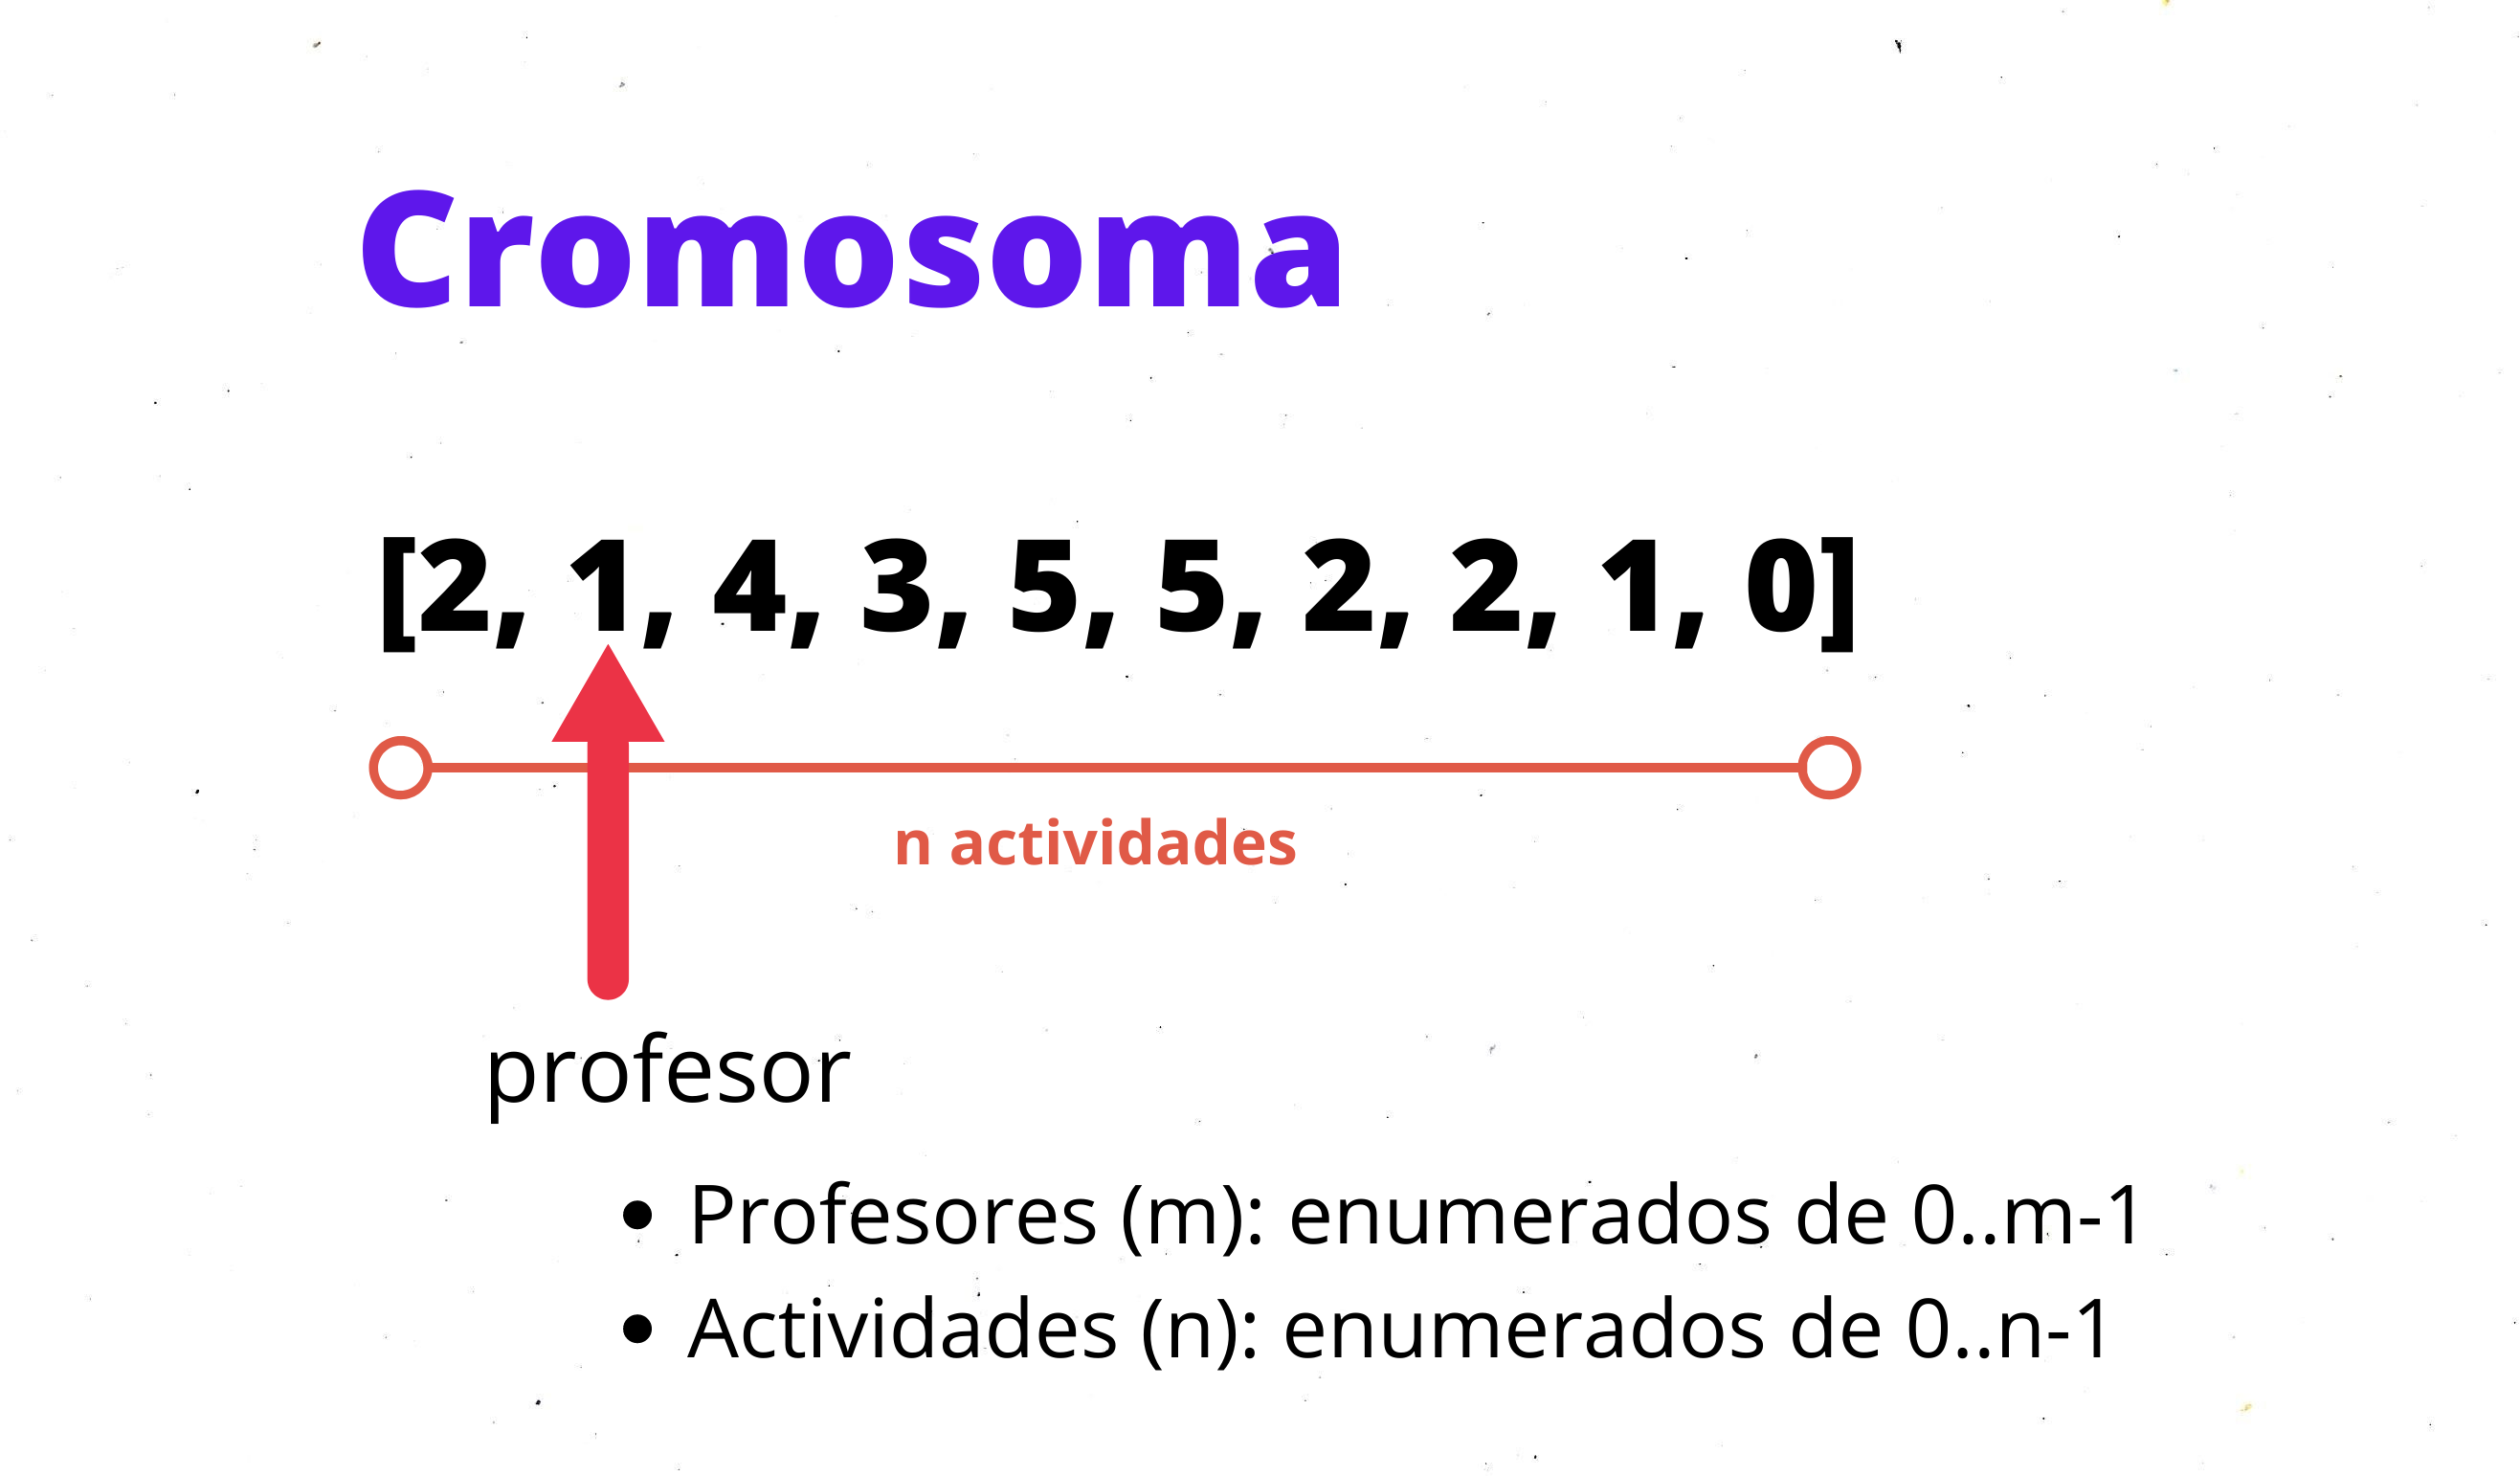

### Representación
El cromosoma representa las actividades y sus profesores asignados.
Se tiene luego una matriz que representa los tiempos que tiene cada profesor de acuerdo a una actividad. Las filas son los profesores y las columnas las actividades.


In [ ]:
n=10
m= 6
cromosoma =  [0 for x in range(0, n)]  # Rellena con profesores de 0..m en activiades de 0..n

mat = [[10, 1, 0, 5, 0,  8, 0, 0, 0, 2],  #Profesores son filas
       [ 0, 2, 0, 6, 0,  0, 5, 0, 5, 3],  #Actividades son columnas
       [ 7, 0, 3, 0, 8,  0, 6, 7, 4, 0],
       [ 0, 0, 4, 5, 9, 10, 5, 8, 3, 0],
       [ 0, 1, 3, 0, 0,  0, 0, 0, 3, 0],
       [ 6, 0, 5, 7, 8,  7, 7, 9, 4, 5]]


Para guiar al algoritmo genético creamos una función fitness que devuelve 2 resultados distintos dependiendo de la situación:
Casos:
 1.- Todos los profesores asignados a cada actividad son capaces de enseñarla (En la matriz no tiene '0' en ese valor)
 2.- Existe algún profesor que no es capaz de enseñar la actividad asignada (En la matriz tiene '0' en ese valor)
 
 Desarrollamos dos funciones fitness cuando hicimos este ejercicio, la primera era para el caso donde no hay dependencias entre las tareas "fitness9" y "fitness9_2" es con estas dependencias. 
 
 Para estos dos casos se utiliza un valor especial para penalizar el valor de fitness para ese cromosoma si alguno de los valores devueltos por la matriz para un profesor y actividad es igual a '0'. En este caso se utiliza el valor de la siguiente función "peorTiempoMatriz" que devuelve el peor tiempo que hay en esa matriz por algún profesor en alguna actividad. De esta manera se suma ese tiempo en vez de sumar el valor '0' en la suma de los tiempos totales. Así cuando minimizamos, los mejores cromosomas serán aquellos dónde las actividades si son hechas por un profesor que las puede enseñar.

In [ ]:
def peorTiempoMatriz(matriz, n, m):
    ma = -1
    for i in range(0,m):
        for j in range(0,n):
            if ma==-1:
                ma= mat[i][j]
            ma = max(ma, mat[i][j])
    return ma

peorTiempo = peorTiempoMatriz(mat, n,m)

De esta manera el valor "peorTiempo" es el peor tiempo que tiene un profesor en una actividad en este ejemplo

In [ ]:
peorTiempo

### Decodifica
La decodificación recibe un cromosoma y devuelve una lista del tamaño de las actividades con los tiempos de cada actividad dependiendo del profesor asignado. Si el profesor no es capaz de realizar esta actividad, inserta un -1 en esa actividad. Si es capaz, inserta el tiempo. Lo decodificamos así ya que esta es la información importante que necesita fitness para otorgarle el valor de calidad a la solución

In [ ]:
def decodifica(cromosoma, n, matriz):
    l = []
    for i in range(n):
        ##i es la actividad, el valor "prof" es el profesor
        prof = cromosoma[i]
        if mat[prof][i] > 0:
            l.append(prof)
        else:
            l.append(-1)
    return l  ##Devuelve la lista de actividades con sus profesores, si la actividad no se puede hacer con ese profesor
               ##, devuelve -1

In [ ]:
decodifica([0, 1, 1, 0, 3, 4, 5, 3, 4, 1], n,mat)

### Fitness:  
#### Sin dependencias entre actividades

La función fitness primero guarda todos los tiempos de los profesores que están en el cromosoma, sumando sus tiempos dependiendo de la actividad que tienen asignada. 
Todos estos tiempos se guardan en "tiempoProf".

Si recorriendo el cromosoma encuentra que una actividad tiene asignada a un profesor que no puede dar esa actividad, aumenta el contador "contIncorrectas" que es el contador de asignaciones incorrectas. 

Luego recorre el array de tiempos de los profesores y guarda el valor maximo en ese array.

Penalización p: Finalmente multiplica el valor "contIncorrectas" con "peorTiempo" que es el valor que utilizamos para penalizar este cromosoma cuándo asigna mal a los profesores. Se multiplica por el contador ya que es la cantidad de veces que asignó mal a un profesor. 

Si asignó todo bien, devuelve el valor q que es el valor del tiempo del profesor que tiene más tiempo asignado en esta jornada de informática. En cambio, si existen profesores mal asignados, devuelve el mismo valor q pero sumado con la penalización p.

In [ ]:
##Sin restricciones
def fitness9(cromosoma, n, matriz, peorTiempo):
    profesores = decodifica(cromosoma, n, matriz)
    tiempoProf= [0 for x in range(0, m)]
    q=0
    contIncorrectas=0
    contRes =0
    for i in range(0, n):
        ##i es la actividad, el valor "prof" es el profesor
        if profesores[i]<0:
            contIncorrectas += 1
        prof = cromosoma[i]
        tiempoProf[prof] += mat[prof][i]
        
    for i in range(0, m):
        q = max(q, tiempoProf[i])   ##el profesor que termino de ultimo
                
    p = contIncorrectas*peorTiempo
    
    if contIncorrectas>0:
        return  q + p
    else:
        return q


### Cruce

Cruzamos los cromosomas en un punto de cruce pero este punto será dado al azar con random.randint

 El cruce y su probabilidad de aplicación constituyen aspectos críticos en el diseño del algoritmo. Esto se debe en general a que los espacios de búsqueda resultantes presentan características indeseables, a medida que la función fitness va guiando, con un adecuado cruce los cromosomas que se van obtiendo son cada vez mejor y el cruce terminará dando a lugar a correcciones sistemáticas. Esto es así ya que puede que obtengamos lo mejor de cada padre, dependiendo de la probabilidad.

In [ ]:
import random
def fun_cruzar9(cromosoma1, cromosoma2):
    """Cruza los cromosomas por la mitad"""
    l = len(cromosoma1)
    p = random.randint(0,l-1)
    l1 = len(cromosoma1)
    l2 = len(cromosoma2)
    cruce1 = cromosoma1[0:p]+cromosoma2[p:l2]
    cruce2 = cromosoma2[0:p]+cromosoma1[p:l1]
    return [cruce1,cruce2]

In [ ]:
fun_cruzar9([1,2,3,4,5,6],[-1,-2,-3,-4,-5,-6])

### Mutación

La mutación que necesitamos en este problema incluye cambiar la posición de un profesor para una actividad; nos introduce diversidad a la población, más cómo los mejores cromosomas son los que sobreviven, los profesores que van quedando pueden ser aquellos con los mejores tiempos en varias situaciones, por lo cuál pueden dar a lugar a mutaciones ventajosas.

In [ ]:
def fun_mutar9(cromosoma,prob, n):
    índiceA = random.randint(0, n -1)
    índiceB = random.randint(0, n -1)
    if prob > random.uniform(0, 1):
        cromosoma[índiceA], cromosoma[índiceB] = cromosoma[índiceB], cromosoma[índiceA]
    return cromosoma

### Operadores Genéticos 
#### para el problema sin restricciones

In [ ]:
def fit1_9(cromosoma):
    return fitness9(cromosoma, n, mat, peorTiempo)
def mutar9(cromosoma, prob):
    return fun_mutar9(cromosoma, prob,n)
def decod9(cromosoma):
    return decodifica(cromosoma, n, mat)
def cruza9(cromosoma1, cromosoma2):
    return fun_cruzar9(cromosoma1, cromosoma2)


### Población Inicial

Para generar una población inicial diversa, hacemos que se escojan al azar de entre los m profesores y se reparten en el array de actividades. Esto se hace unas "size" veces. Esto produce una buena aleatoridad a la población.

In [ ]:
def poblacion_inicial(problema_genetico, size):
    l = []
    for i in range(size):
        l.append([random.choice([x for x in range(0, m)]) for i in range(problema_genetico.longitud_individuos)])
    return l

## Ejecución del Problema 

In [ ]:
p9 = ProblemaGenetico([x for x in range(0, m)], decod9, mutar9, cruza9,fit1_9,n)

In [ ]:
poblacion_inicial(p9, 10)

In [ ]:
algoritmo_genetico(p9, 10, min, 50, 10,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9, 50, min, 100, 50,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9, 50, min, 100, 50,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9, 50, min, 100, 50,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9, 50, min, 100, 50,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9, 50, min, 100, 50,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9, 50, min, 100, 50,0.7,0.1 )

### Fitness:  
#### Con dependencias entre actividades

In [ ]:
n = 10
m= 6
graph = {
   0  : [1,2,3],
   1  : [5,4],
   2  : [9],
   3  : [8],
   4  : [6,7],
   5  : [9],
   6  : [8,9],
   7  : [8],
   8  : [],
   9  : [],
}

mat = [[10, 1, 0, 5, 0,  8, 0, 0, 0, 2],  #Profesores son filas
       [ 0, 2, 0, 6, 0,  0, 5, 0, 5, 3],  #Actividades son columnas
       [ 7, 0, 3, 0, 8,  0, 6, 7, 4, 0],
       [ 0, 0, 4, 5, 9, 10, 5, 8, 3, 0],
       [ 0, 1, 3, 0, 0,  0, 0, 0, 3, 0],
       [ 6, 0, 5, 7, 8,  7, 7, 9, 4, 5]]

peorTiempo = peorTiempoMatriz(mat, n,m)


### Algoritmos para operar las dependencias

Como las dependencias se representan con un grafo, lo recorremos con el algoritmo BFS en la función fitness para calcular los tiempos que tendrán algunas actividades dependiendo de las restricciones.

El último paso del algoritmo "bfsTiempo", tranforma los datos que se obtuvieron en "tiemposF" y se tranforman en el array "salida". Este array guarda el mejor tiempo con el que se puede ordenar las actividades según las restricciones.

In [ ]:
def bfsTiempo(visited, graph, node, tiempoAct, tiemposF):
    queue = []
    salida = []
    visited.append(node)
    queue.append(node)
    tiemposF[node].append(tiempoAct[node])
    while queue:
        s = queue.pop(0)
        t = min(tiemposF[s])
        for neighbour in graph[s]:
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)
            else:
                if neighbour<s:
                    tiemposF[neighbour]=[]
            tiemposF[neighbour].append(t + tiempoAct[neighbour])

    for i in tiemposF:
        if len(i)==0:
            salida.append(0)
        else :
            salida.append(min(i))
    return (visited, salida, tiemposF)

Como es un grafo recorrido con el algoritmo BFS, este puede que no se recorra completamente ya que no todos los vértices están conectados entre sí; por ello se hace la siguiente función que es la que se encarga de llamar a "bfsTiempo" para ir recorriendo cada vértice. Si no fue recorrido, no se agregan elementos a las listas y sólo se agregan posibles valores a "tiemposF".

El coste de este algoritmo es el mismo al BFS, es decir, O(V + A)
- V = número de vértices
- A = número de aristas

In [ ]:
def recorrerBFS(graph, tiempoAct, n):
    visited = []
    salida =[]
    tiemposF = [ []for i in tiempoAct]
    for i in range (0,n):
        if i not in visited:
            visited, salida , tiemposF= bfsTiempo(visited , graph, i, tiempoAct, tiemposF)
    return salida

### Función fitness

Realiza lo mismo que la función fitness, más en este caso se llama a la función "recorrerBFS" y luego los valores de su resultado "tiemposF" se comparan con los tiempos máximos al sumar los tiempos de cada uno de los profesores en todas las actividades en las que participan. El tiempo máximo entre estos dos array, es el valor q.

q será entonces el menor tiempo en el que se puede realizar estas actividades con estos profesores. 

Las mismas penalizaciones que se hicieron en la anterior función fitness se usan en esta misma función.

In [ ]:
##Con restricciones
def fitness9_2(cromosoma, n, m, matriz, peorTiempo):
    profesores = decodifica(cromosoma, n, matriz)
    contIncorrectas =0
    tiempoProf = [0 for x in range(0, m)]
    tiemposAct = [0 for i in range(0,n)]
    for i in range(0, n):
        if profesores[i] < 0:
            contIncorrectas +=1
        prof = cromosoma[i]
        tiemposAct[i] = mat[prof][i]
        tiempoProf[prof] +=mat[prof][i]

    tiemposF = recorrerBFS(graph, tiemposAct, n)


    q = max(max(tiempoProf),max(tiemposF))

    p = contIncorrectas * peorTiempo
    if contIncorrectas > 0:
        return q + p
    else:
        return q

### Operadores Genéticos 
#### para el problema con restricciones

In [ ]:
def fit1_9R(cromosoma):
    return fitness9_2(cromosoma, n,m, mat, peorTiempo)
def mutar9(cromosoma, prob):
    return fun_mutar9(cromosoma, prob, n)
def decod9(cromosoma):
    return decodifica(cromosoma, n, mat)
def cruza9(cromosoma1, cromosoma2):
    return fun_cruzar9(cromosoma1, cromosoma2)

## Ejecución del Problema 

In [ ]:
p9R = ProblemaGenetico([x for x in range(0, m)], decod9, mutar9, cruza9,fit1_9R,n)

In [ ]:
algoritmo_genetico(p9R, 10, min, 50, 10,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9R, 10, min, 100, 10,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9, 50, min, 100, 50,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9, 50, min, 100, 50,0.7,0.1 )

# Pruebas para el problema

## -----------------------------------------------------------------------------------------------------------------------------

## Prueba 1: 
#### Sin dependencias

No hay dependencias entre las actividades (es decir, todas se podrían dar a la vez).  Todas las actividades misma duración (60 min).  Las restricciones indican lo que sabe dar cada profesor y, en esta prueba, se da una situación muy sencilla.

Sabemos que Profesor1 sabe dar los talleres:  taller1, taller2  en 60 min (cada uno) y lo expresamos como:   (profesor1, taller1, 60) (profesor1, taller2, 60)

El resto de profesores:

(profesor2, taller3, 60) (profesor2, taller4, 60)

(profesor3, taller5, 60) (profesor3, taller6, 60)

(profesor4, taller7, 60) (profesor4, taller8, 60)

(profesor5, taller9, 60) (profesor5, taller10, 60)

Hay varias soluciones de tiempo mínimo que será de 120 minutos.  Modificando los tiempos de los talleres se debe ajustar el tiempo total de la solución.

<h3 style="color:orange;">Algoritmo genético </h3>

In [ ]:
n=10
m =5

mat = [[60, 60, 0, 0, 0,  0, 0, 0, 0, 0],  #Profesores son filas
       [ 0, 0, 60, 60, 0,  0, 0, 0, 0, 0],  #Actividades son columnas
       [ 0, 0, 0, 0, 60,  60, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0,  0, 60, 60, 0, 0],
       [ 0, 0, 0, 0, 0,  0, 0, 0, 60, 60]]
peorTiempo = peorTiempoMatriz(mat, n,m)

In [ ]:
# k:             número de participantes en los torneos de selección.
# opt:           max ó min, dependiendo si el problema es de maximización o de minimización. 
# nGen:          número de generaciones (que se usa como condición de terminación)
# size:          número de individuos en cada generación
# prop_cruce:    proporción del total de la población que serán padres. 
# prob_mutación: probabilidad de realizar una mutación de un gen.

In [ ]:
p1 = ProblemaGenetico([x for x in range(0, m)], decod9, mutar9, cruza9,fit1_9,n)

Como queremos obtener las mejores soluciones, podemos:
- aumentar la k del torneo, para tener una presión de selección elevada. Así se centra la búsqueda de las soluciones en un entorno próximo a las mejores soluciones actuales.
- Aumentar el número de generaciones e individuos: para que vayan mutando y cruzando los padresy vamos obteniendo los óptimos hijos que se generan luego de pasar por la selección por torneo


### Caso

- 10 participantes en torneo
- 50 generaciones
- 10 número de individuos en cada generación

La solución se queda en óptimos locales

In [ ]:
algoritmo_genetico(p1, 10, min, 50, 10,0.7,0.1 )

In [ ]:
algoritmo_genetico(p1, 10, min, 50, 10,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 80 generaciones
- 10 número de individuos en cada generación

La solución puede obtenerse pero requiere varias ejecuciones del algoritmo

In [ ]:
algoritmo_genetico(p1, 10, min, 80, 10,0.7,0.1 )

In [ ]:
algoritmo_genetico(p1, 10, min, 80, 10,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 50 generaciones
- 30 número de individuos en cada generación

La solución puede obtenerse pero requiere varias ejecuciones del algoritmo

In [ ]:
algoritmo_genetico(p1, 10, min, 50,30,0.7,0.1 )

In [ ]:
algoritmo_genetico(p1, 10, min, 50,30,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 100 generaciones
- 50 número de individuos en cada generación

Debido a la cantidad de generaciones e individuos, el algoritmo alcanza la mejor solución siempre.

In [ ]:
algoritmo_genetico(p1, 10, min, 100, 50,0.7,0.1 )

<h3 style="color:orange;">Hill Climbing</h3>

In [ ]:
from search import *
class JornadaInfo_problem(Problem):
    
    """ subclass of Problem to define various functions """

    def two_opt(self, state):
        """ Neighbour generating function for Traveling Salesman Problem """
        neighbour_state = state[:]
        p = random.randint(0,len(state)-1)
        prof = random.randint(0,m-1)
        neighbour_state[p] = prof
        return neighbour_state

    def actions(self, state):
        """ action that can be excuted in given state """
        return [self.two_opt]

    def result(self, state, action):
        """  result after applying the given action on the given state """
        return action(state)

    def path_cost(self, c, state1, action, state2):
        return fitness9(state2,n,  mat, peorTiempo )

    def value(self, state):
        """ value of path cost given negative for the given state """
        return self.path_cost(None, None, None, state)

In [ ]:
HC_9 = JornadaInfo_problem([random.randint(0,m-1) for x in range(0, n)])

In [ ]:
%time sol1= hill_climbing(HC_9)
print("Valor de sol:", HC_9.value(sol1))
sol1

In [ ]:
%time sol1= hill_climbing(HC_9)
print("Valor de sol2:", HC_9.value(sol1))
sol1

In [ ]:
%time sol1= hill_climbing(HC_9)
print("Valor de sol3:", HC_9.value(sol1))
sol1

In [ ]:
%time sol1= hill_climbing(HC_9)
print("Valor de sol4:", HC_9.value(sol1))
sol1

#### Conclusión:
El algoritmo de hill climbing funciona mal con este tipo de problema ya que hay muchos óptimos locales en los cuales se queda atascado. Por eso en algunas ejecuciones se tarda 7 u 8 segundos y en otras 0 segundos. Los óptimos locales no son ni siquiera ceranos a los mejores óptimos locales y menos aún el óptimo global

<h3 style="color:orange;">Simulated Annealing</h3>

In [ ]:
import math
def simulated_annealing(problem, schedule=exp_schedule()):
    """[Figure 4.5] CAUTION: This differs from the pseudocode as it
    returns a state instead of a Node."""
    current = Node(problem.initial)
    for t in range(sys.maxsize):
        T = schedule(t)
        if T == 0:
            return current.state
        neighbors = current.expand(problem)
        if not neighbors:
            return current.state
        next_choice = random.choice(neighbors)
        delta_e = problem.value(current.state) -problem.value(next_choice.state)
        if delta_e > 0 or probability(math.exp(delta_e / T)):
            current = next_choice

In [ ]:
SA_9 = JornadaInfo_problem([random.randint(0,m-1) for x in range(0, n)])

In [ ]:
%time sol1= min([simulated_annealing(SA_9) for i in range(100)])
print(sol1)
print("Valor de sol1:", SA_9.value(sol1))

In [ ]:
%time sol1= min([simulated_annealing(SA_9) for i in range(100)])
print(sol1)
print("Valor de sol2:", SA_9.value(sol1))

In [ ]:
%time sol1= min([simulated_annealing(SA_9) for i in range(100)])
print(sol1)
print("Valor de sol3:", SA_9.value(sol1))

#### Conclusión:
El algoritmo de Simulated Annealing funciona mejor ya que es capaz de salir de los óptimos locales, empeorar dependiendo de la temperatura e ir acercádose a mejores tiempos. Desgraciadamente el algoritmo en muchas ejecuciones hechas, no logró llegar al óptimo global que es la solución:

([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], 120)

Pero se acercó mucho con un óptimo local con tiempo 180, siendo este resultado: [0, 0, 0, 1, 2, 2, 3, 3, 4, 4]

Para poder adaptar este algoritmo a nuestro ejercicio, como es buscando el mínimo tiempo, cambiamos el valor de delta_e:
delta_e = problem.value(current.state) -problem.value(next_choice.state)

## -----------------------------------------------------------------------------------------------------------------------------

## Prueba 2

Seguimos sin dependencias entre actividades pero ahora los profesores saben dar distintos talleres, algunos talleres pueden ser impartidos por distintas personas de momento con los mismos tiempos.

(profesor1, taller1, 60) (profesor1, taller2, 60) (profesor1, taller3, 60)

(profesor2, taller1, 60) (profesor2, taller2, 60) (profesor2, taller3, 60) (profesor2, taller4, 60)

(profesor3, taller1, 60) (profesor3, taller2, 60) (profesor3, taller3, 60) (profesor3, taller4, 60) (profesor3, taller5, 60) (profesor3, taller6, 60)

(profesor4, taller1, 60) (profesor4, taller2, 60) (profesor4, taller3, 60) (profesor4, taller4, 60) (profesor4, taller6, 60) (profesor4, taller7, 60)

(profesor5, taller1, 60) (profesor5, taller2, 60) (profesor5, taller3, 60) (profesor5, taller4, 60) (profesor5, taller5, 60) (profesor5, taller6, 60) (profesor5, taller7, 60) (profesor5, taller8, 60) (profesor5, taller9, 60) (profesor5, taller10, 60)

La mejor solución no ocupará al profesor5 en el taller1 ya que sólo él puede dar los talleres 8, 9 y  10. No hay una solución en menos de 180 minutos.

In [ ]:
n=10
m =5

mat = [[ 60, 60, 60, 0, 0,  0, 0, 0, 0, 0],
       [ 60, 60, 60, 60, 0,  0, 0, 0, 0, 0],
       [ 60, 60, 60, 60, 60,  60, 0, 0, 0, 0],
       [ 60, 60, 60, 60, 0,  60, 60, 0, 0, 0],
       [ 60, 60, 60, 60, 60,  60, 60, 60, 60, 60]]
peorTiempo = peorTiempoMatriz(mat, n,m)

In [ ]:
p2 = ProblemaGenetico([x for x in range(0, m)], decod9, mutar9, cruza9,fit1_9,n)

### Caso

- 10 participantes en torneo
- 50 generaciones
- 10 número de individuos en cada generación

La solución puede obtenerse pero requiere varias ejecuciones del algoritmo

In [ ]:
algoritmo_genetico(p2, 10, min, 50, 10,0.7,0.1 )

In [ ]:
algoritmo_genetico(p2, 10, min, 50, 10,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 100 generaciones
- 50 número de individuos en cada generación

Debido a la cantidad de generaciones e individuos, el algoritmo alcanza la mejor solución siempre.

In [ ]:
algoritmo_genetico(p2, 10, min, 100, 50,0.7,0.1 )

## -----------------------------------------------------------------------------------------------------------------------------

## Prueba 3

Mismos casos que la prueba 2 pero si el profesor 4 sabe dar el taller8 hay soluciones en 120 minutos.

In [ ]:
n=10
m =5

mat = [[ 60, 60, 60, 0, 0,  0, 0, 0, 0, 0],
       [ 60, 60, 60, 60, 0,  0, 0, 0, 0, 0],
       [ 60, 60, 60, 60, 60,  60, 0, 0, 0, 0],
       [ 60, 60, 60, 60, 0,  60, 60, 60, 0, 0],
       [ 60, 60, 60, 60, 60,  60, 60, 60, 60, 60]]
peorTiempo = peorTiempoMatriz(mat, n,m)

In [ ]:
p3 = ProblemaGenetico([x for x in range(0, m)], decod9, mutar9, cruza9,fit1_9,n)

### Caso

- 10 participantes en torneo
- 50 generaciones
- 10 número de individuos en cada generación

La solución se queda en óptimos locales

In [ ]:
algoritmo_genetico(p3, 10, min, 50, 10,0.7,0.1 )

In [ ]:
algoritmo_genetico(p3, 10, min, 50, 10,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 50 generaciones
- 40 número de individuos en cada generación

La solución se queda en óptimos locales

In [ ]:
algoritmo_genetico(p3, 10, min, 50, 40,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 50 generaciones
- 10 número de individuos en cada generación

La solución puede obtenerse pero requiere varias ejecuciones del algoritmo

In [ ]:
algoritmo_genetico(p3, 10, min, 80, 40,0.7,0.1 )

In [ ]:
algoritmo_genetico(p3, 10, min, 80, 40,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 100 generaciones
- 50 número de individuos en cada generación

Debido a la cantidad de generaciones e individuos, el algoritmo puede dar a lugar el mejor resultado con mayor probabilidad 

In [ ]:
algoritmo_genetico(p3, 10, min, 100, 50,0.7,0.1 )

In [ ]:
algoritmo_genetico(p3, 10, min, 100, 50,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 200 generaciones
- 80 número de individuos en cada generación

Debido a la cantidad de generaciones e individuos, el algoritmo alcanza la mejor solución siempre.

In [ ]:
algoritmo_genetico(p3, 10, min, 200, 80,0.7,0.1 )

## -----------------------------------------------------------------------------------------------------------------------------

## Prueba 4

(profesor1, taller1, 60) (profesor1, taller2, 60) (profesor1, taller3, 60)

(profesor2, taller1, 60) (profesor2, taller2, 90) (profesor2, taller3, 90) (profesor2, taller4, 100)

(profesor3, taller1, 50) (profesor3, taller2, 50) (profesor3, taller3, 50) (profesor3, taller4, 50) (profesor3, taller5, 50) (profesor3, taller6, 50)

(profesor4, taller1, 30) (profesor4, taller2, 30) (profesor4, taller3, 40) (profesor4, taller4, 40) (profesor4, taller6, 50) (profesor4, taller7, 60)

(profesor5, taller1, 40) (profesor5, taller2, 40) (profesor5, taller3, 40) (profesor5, taller4, 40) (profesor5, taller5, 40) (profesor5, taller6, 40) (profesor5, taller7, 40) (profesor5, taller8, 40) (profesor5, taller9, 40) (profesor5, taller10, 40)

 

Hay soluciones en 120 minutos.

In [ ]:
n=10
m =5

mat = [[ 60, 60, 60, 0, 0,  0, 0, 0, 0, 0],
       [ 60, 90, 90, 100, 0,  0, 0, 0, 0, 0],
       [ 50, 50, 50, 50, 50,  50, 0, 0, 0, 0],
       [ 30, 30, 40, 40, 0,  50, 0, 60, 0, 0],
       [ 40, 40, 40, 40, 40,  40, 40, 40, 40, 40]]
peorTiempo = peorTiempoMatriz(mat, n,m)

In [ ]:
p4 = ProblemaGenetico([x for x in range(0, m)], decod9, mutar9, cruza9,fit1_9,n)

### Caso

- 10 participantes en torneo
- 50 generaciones
- 10 número de individuos en cada generación

La solución puede obtenerse pero requiere varias ejecuciones del algoritmo. Se queda en óptimos locales.

In [ ]:
algoritmo_genetico(p4, 10, min, 50, 10,0.7,0.1 )

In [ ]:
algoritmo_genetico(p3, 10, min, 100, 50,0.7,0.1 )

In [ ]:
algoritmo_genetico(p3, 10, min, 100, 50,0.7,0.1 )

## -----------------------------------------------------------------------------------------------------------------------------

## Prueba 5

profesor1, taller1, 60) (profesor1, taller2, 60)

(profesor2, taller3, 60) (profesor2, taller4, 60)

(profesor3, taller5, 60) (profesor3, taller6, 60)

(profesor4, taller7, 60) (profesor4, taller8, 60)

(profesor5, taller9, 60) (profesor5, taller10, 60)

 

.  Dependencia taller2 < taller 1.  Lo representamos (taller2, taller1)  indica que  taller 2 hay que impartirlo antes de taller 1

Con las dependencias:

o   (taller2, taller1)

o   (taller4, taller3)

o   (taller6, taller5)

o   (taller8, taller7)

o   (taller10, taller9)

Soluciones en 120 minutos.

In [ ]:
n = 10
m= 5

mat = [[ 60, 60, 0, 0, 0,  0, 0, 0, 0, 0],
       [ 0, 0, 60, 60, 0,  0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 60,  60, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0,  0, 60, 60, 0, 0],
       [ 0, 0, 0, 0, 0,  0, 0, 0, 60, 60]]
peorTiempo = peorTiempoMatriz(mat, n,m)

In [ ]:
graph = {
   0  : [ ],
   1  : [0],
   2  : [ ],
   3  : [2],
   4  : [ ],
   5  : [4],
   6  : [5],
   7  : [6],
   8  : [ ],
   9  : [8]
}

In [ ]:
p9R5 = ProblemaGenetico([x for x in range(0, m)], decod9, mutar9, cruza9,fit1_9R,n)

### Caso

- 10 participantes en torneo
- 50 generaciones
- 10 número de individuos en cada generación

La solución puede obtenerse pero requiere varias ejecuciones del algoritmo. Se queda en óptimos locales.

In [ ]:
algoritmo_genetico(p9R5, 10, min, 50, 10,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9R5, 10, min, 100, 50,0.7,0.1 )

### Caso

- 10 participantes en torneo
- 100 generaciones
- 20 número de individuos en cada generación

La solución puede obtenerse pero requiere varias ejecuciones del algoritmo. Se queda en óptimos locales.

In [ ]:
algoritmo_genetico(p9R5, 10, min, 100, 20,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9R5, 10, min, 100, 20,0.7,0.1 )

## -----------------------------------------------------------------------------------------------------------------------------

## Prueba 6

 La misma información de profesores que la prueba 5 con las dependencias

o   (taller2, taller1)

o   (taller2, taller3)

o   (taller3, taller4)

o   (taller5, taller7)

 
Soluciones en 180 minutos.

In [ ]:
n = 10
m= 5

mat = [[ 60, 60, 0, 0, 0,  0, 0, 0, 0, 0],
       [ 0, 0, 60, 60, 0,  0, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 60,  60, 0, 0, 0, 0],
       [ 0, 0, 0, 0, 0,  0, 60, 60, 0, 0],
       [ 0, 0, 0, 0, 0,  0, 0, 0, 60, 60]]
peorTiempo = peorTiempoMatriz(mat, n,m)

In [ ]:
graph = {
   0  : [ ],
   1  : [0,2],
   2  : [3],
   3  : [ ],
   4  : [6],
   5  : [ ],
   6  : [ ],
   7  : [ ],
   8  : [ ],
   9  : [ ]
}

In [ ]:
p9R5 = ProblemaGenetico([x for x in range(0, m)], decod9, mutar9, cruza9,fit1_9R,n)

### Casos

- 10 participantes en torneo
- 50 generaciones
- 10 número de individuos en cada generación

Se queda en óptimos locales.

In [ ]:
algoritmo_genetico(p9R5, 10, min, 50, 10,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9R5, 10, min, 50, 10,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 100 generaciones
- 20 número de individuos en cada generación

La solución puede obtenerse pero requiere varias ejecuciones del algoritmo

In [ ]:
algoritmo_genetico(p9R5, 10, min, 100, 20,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9R5, 10, min, 100, 20,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 100 generaciones
- 20 número de individuos en cada generación

Debido a la cantidad de generaciones e individuos, el algoritmo alcanza la mejor solución siempre.

In [ ]:
algoritmo_genetico(p9R5, 10, min, 100, 50,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9R5, 10, min, 100, 50,0.7,0.1 )

## -----------------------------------------------------------------------------------------------------------------------------

## Prueba 7

(profesor1, taller1, 60) (profesor1, taller2, 60) (profesor1, taller3, 60)

(profesor2, taller1, 60) (profesor2, taller2, 90) (profesor2, taller3, 90) (profesor2, taller4, 100)

(profesor3, taller1, 50) (profesor3, taller2, 50) (profesor3, taller3, 50) (profesor3, taller4, 50) (profesor3, taller5, 50) (profesor3, taller6, 50)

(profesor4, taller1, 30) (profesor4, taller2, 30) (profesor4, taller3, 40) (profesor4, taller4, 40) (profesor4, taller6, 50) (profesor4, taller7, 60)

(profesor5, taller1, 40) (profesor5, taller2, 40) (profesor5, taller3, 40) (profesor5, taller4, 40) (profesor5, taller5, 40) (profesor5, taller6, 40) (profesor5, taller7, 40) (profesor5, taller8, 40) (profesor5, taller9, 40) (profesor5, taller10, 40)

Dependencias temporales:

(taller 1, taller 8)

(taller7, taller6)

Solución en 150 minutos.

In [ ]:
n=10
m =5

mat = [[ 60, 60, 60, 0, 0,  0, 0, 0, 0, 0],
       [ 60, 90, 90, 100, 0,  0, 0, 0, 0, 0],
       [ 50, 50, 50, 50, 50,  50, 0, 0, 0, 0],
       [ 30, 30, 40, 40, 0,  50, 0, 60, 0, 0],
       [ 40, 40, 40, 40, 40,  40, 40, 40, 40, 40]]
peorTiempo = peorTiempoMatriz(mat, n,m)

In [ ]:
graph = {
   0  : [7],
   1  : [ ],
   2  : [ ],
   3  : [ ],
   4  : [ ],
   5  : [ ],
   6  : [5],
   7  : [ ],
   8  : [ ],
   9  : [ ]
}

In [ ]:
p9R5 = ProblemaGenetico([x for x in range(0, m)], decod9, mutar9, cruza9,fit1_9R,n)

### Casos

- 10 participantes en torneo
- 50 generaciones
- 10 número de individuos en cada generación

Se queda en óptimos locales.

In [ ]:
algoritmo_genetico(p9R5, 10, min, 50, 10,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 100 generaciones
- 20 número de individuos en cada generación

La solución puede obtenerse pero requiere varias ejecuciones del algoritmo

In [ ]:
algoritmo_genetico(p9R5, 10, min, 100, 20,0.7,0.1 )

In [ ]:
algoritmo_genetico(p9R5, 10, min, 100, 20,0.7,0.1 )

### Caso
- 10 participantes en torneo
- 100 generaciones
- 50 número de individuos en cada generación

Debido a la cantidad de generaciones e individuos, el algoritmo alcanza la mejor solución siempre.

In [ ]:
algoritmo_genetico(p9R5, 10, min, 100, 50,0.7,0.1 )

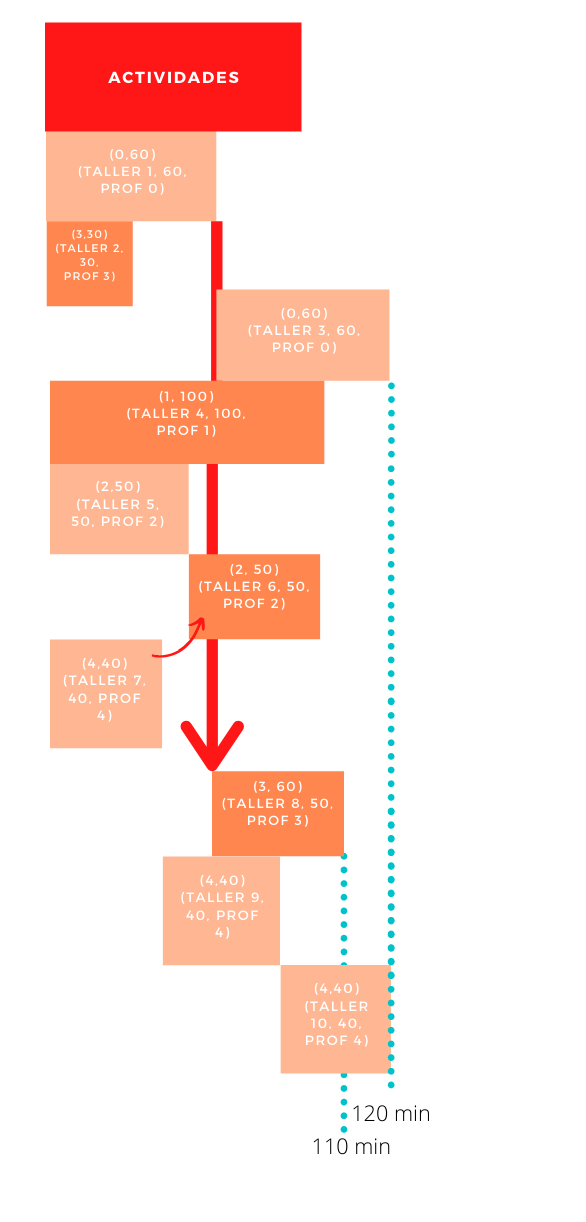